# Notebook to train the Hybrid ResNet-ViT

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet
from models3D import ResnetFeatureExtractor, ResNetViT
import json
import pprint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-08 12:53:35.776496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-08 12:53:36.643659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [ ]:
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

USE_MASK = False # Set to True to use the ROI mask, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
    Found 575 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
    Found 143 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])


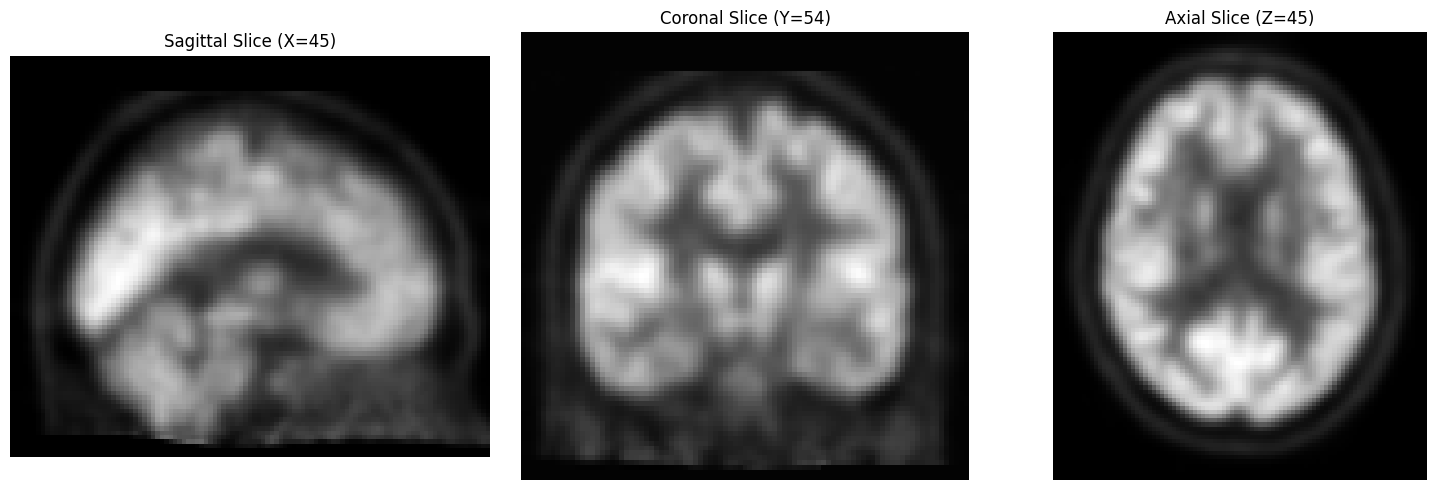

In [4]:
# Verify data with a test sample
i = 1
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    break

In [ ]:
use_pretrained = False
if use_pretrained:
    resnet_path = "/home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.0e-05_WD=1e-04 (sgd)/model.pth"
    dir1 = "no_pretrain/"
else:
    resnet_path = None
    dir1 = "pretrain/"
resnet_config = {
    'block': 'basic',
    'layers': [3, 4, 6, 3],
    'block_inplanes': [64, 128, 256, 512],
    'spatial_dims': 3,
    'n_input_channels': 1,
    'conv1_t_stride': 2,
    'num_classes': 1, 
    'shortcut_type': 'B',
    'bias_downsample': False
}

vit_config = {
    'in_channels': 256,
    'img_size': (6,7,6),
    'patch_size': (1,1,1),
    'num_heads': 4,
    'hidden_size': 258,
    'mlp_dim': 1032,
    'num_layers': 6,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.0,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': False
}

pure_vit_config = {
    'in_channels': 1,
    'img_size': (91,109,91),
    'patch_size': (16,16,16),
    'num_heads': 5,
    'hidden_size': 300,
    'mlp_dim': 1200,
    'num_layers': 6,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.0,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': False
}


In [ ]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 150
EARLY_STOP_PATIENCE = 60

lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

learning_rates = [2e-7] # usar valores a volta do 1e-6 (ate agr a combinacao com l2=1e-4 ou 5e-4 pareceu a melhor com val loss min de 0.24 em 32 epochs)
weight_decays = [2e-4]

tuning_results = []
total_combinations = len(learning_rates) * len(weight_decays)
current_combination_no = 0

if lr_scheduler == "fixed_lr":
    dir2 = "fixed_lr/"
elif lr_scheduler == "cosine_decay":
    dir2 = "cosine_decay/"

if lr_scheduler == "cosine_decay":
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/resnetvit/" + DATASET + "/" + dir1 + dir2 + str(BATCH_SIZE) + "B/"
elif lr_scheduler == "fixed_lr":
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/resnetvit/" + DATASET + "/" + dir1 + dir2 + str(BATCH_SIZE) + "B/"
else:
    raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

# Hyperparameter tuning loop
for current_lr in learning_rates:
    for current_wd in weight_decays: 
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        print("=" * 60)
        start_time_combination = time.time()

        combo_dir_name = f"LR0_{current_lr:.1e}_WD_{current_wd:.0e}" 
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                 raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            ) 
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                 raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
             
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            resnet_feature_extractor = ResnetFeatureExtractor(resnet_config=resnet_config, device=device, trained_path=resnet_path, use_pretrained=use_pretrained)
            model = ResNetViT(resnet_feature_extractor, vit_config).to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            #optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=current_lr, weight_decay=current_wd, momentum=0.9, nesterov=True)
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=current_lr, weight_decay=current_wd)
                    
            scheduler = None
            if lr_scheduler == "cosine_decay":
                print("\nUsing Cosine Annealing LR Scheduler.\n")
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-8)
    
            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # Train phase
                model.train()
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())
 
                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # Validation phase
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                      f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                      f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                
                if scheduler:
                    scheduler.step()

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the best model state
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    stopped_epoch = epoch + 1
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {stopped_epoch - epochs_no_improve}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            optimizer_name = optimizer.__class__.__name__
            
            # Free resources
            del model, optimizer, criterion, scheduler, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)

        print("-" * 50)
        print(f"Results for LR={current_lr}, WeightDecay={current_wd} (Across {N_SPLITS} Folds):")
        print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
        print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
        print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
        print("-" * 50)

        combo_average_results = {
            'learning_rate': current_lr,
            'weight_decay': current_wd,
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch)
        }
        
        # Store results
        tuning_results.append(combo_average_results)
        
        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.")
        
        # Save results in a txt file and the parameters in a json file
        results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())
        
        results_file_path = os.path.join(combo_results_dir, "resultados.txt")
        with open(results_file_path, "w") as f:
            print("\nTuning Results Summary:", file=f)
            print(results_df[display_cols].round(6).to_string(index=False), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)
        
        training_config = {
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(current_lr),
                "weight_decay": float(current_wd)
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)


Results will be saved to: /home/diogommiranda/tese/outputs/resnetvit/smci_pmci/fixed_lr/CROSS_VALIDATION/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=1.0e-05, WeightDecay=1e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/resnetvit/smci_pmci/fixed_lr/CROSS_VALIDATION/LR0_1.0e-05_WD_1e-04
------------------------------------------------------------
Training Fold 1/5 for LR=1.0e-05 and WD=1e-04...
  Train samples: 726, Validation samples: 163
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 472, 1: 254}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8583
Training from scratch...


  1%|          | 1/150 [00:15<39:01, 15.71s/it]

    Epoch 1/150 [15.71s] - Train Loss: 0.91321, Train Acc: 0.49725 | Val Loss: 0.90906, Val Acc: 0.36810


  1%|▏         | 2/150 [00:30<37:12, 15.09s/it]

    Epoch 2/150 [14.65s] - Train Loss: 0.91182, Train Acc: 0.49174 | Val Loss: 0.92080, Val Acc: 0.36810


  2%|▏         | 3/150 [00:44<36:24, 14.86s/it]

    Epoch 3/150 [14.59s] - Train Loss: 0.91345, Train Acc: 0.48623 | Val Loss: 0.90882, Val Acc: 0.36810


  3%|▎         | 4/150 [00:59<36:15, 14.90s/it]

    Epoch 4/150 [14.96s] - Train Loss: 0.90653, Train Acc: 0.52755 | Val Loss: 0.93049, Val Acc: 0.36810


  3%|▎         | 5/150 [01:14<35:40, 14.76s/it]

    Epoch 5/150 [14.52s] - Train Loss: 0.91188, Train Acc: 0.49449 | Val Loss: 0.92038, Val Acc: 0.63190


  4%|▍         | 6/150 [01:29<35:24, 14.75s/it]

    Epoch 6/150 [14.73s] - Train Loss: 0.90371, Train Acc: 0.50413 | Val Loss: 0.91815, Val Acc: 0.63190


  5%|▍         | 7/150 [01:43<35:00, 14.69s/it]

    Epoch 7/150 [14.56s] - Train Loss: 0.90527, Train Acc: 0.52755 | Val Loss: 0.90723, Val Acc: 0.36810


  5%|▌         | 8/150 [01:58<34:50, 14.72s/it]

    Epoch 8/150 [14.78s] - Train Loss: 0.90772, Train Acc: 0.48072 | Val Loss: 0.90469, Val Acc: 0.47853


  6%|▌         | 9/150 [02:13<34:28, 14.67s/it]

    Epoch 9/150 [14.55s] - Train Loss: 0.90053, Train Acc: 0.55372 | Val Loss: 0.90500, Val Acc: 0.36810


  7%|▋         | 10/150 [02:27<34:19, 14.71s/it]

    Epoch 10/150 [14.80s] - Train Loss: 0.90491, Train Acc: 0.49725 | Val Loss: 0.90484, Val Acc: 0.50920


  7%|▋         | 11/150 [02:42<34:03, 14.70s/it]

    Epoch 11/150 [14.69s] - Train Loss: 0.90365, Train Acc: 0.48072 | Val Loss: 0.91141, Val Acc: 0.63190


  8%|▊         | 12/150 [02:57<33:50, 14.71s/it]

    Epoch 12/150 [14.74s] - Train Loss: 0.89915, Train Acc: 0.52755 | Val Loss: 0.93895, Val Acc: 0.63190


  9%|▊         | 13/150 [03:12<33:37, 14.73s/it]

    Epoch 13/150 [14.76s] - Train Loss: 0.90091, Train Acc: 0.51928 | Val Loss: 0.94820, Val Acc: 0.63190


  9%|▉         | 14/150 [03:26<33:22, 14.72s/it]

    Epoch 14/150 [14.72s] - Train Loss: 0.89606, Train Acc: 0.51653 | Val Loss: 0.93701, Val Acc: 0.63190


 10%|█         | 15/150 [03:41<33:15, 14.78s/it]

    Epoch 15/150 [14.92s] - Train Loss: 0.89586, Train Acc: 0.56474 | Val Loss: 0.91402, Val Acc: 0.36810


 11%|█         | 16/150 [03:56<32:51, 14.71s/it]

    Epoch 16/150 [14.54s] - Train Loss: 0.89761, Train Acc: 0.51240 | Val Loss: 0.91206, Val Acc: 0.63190


 11%|█▏        | 17/150 [04:11<32:51, 14.82s/it]

    Epoch 17/150 [15.09s] - Train Loss: 0.89289, Train Acc: 0.52342 | Val Loss: 0.89733, Val Acc: 0.52761


 12%|█▏        | 18/150 [04:26<32:37, 14.83s/it]

    Epoch 18/150 [14.85s] - Train Loss: 0.88483, Train Acc: 0.58127 | Val Loss: 0.90246, Val Acc: 0.36810


 13%|█▎        | 19/150 [04:41<32:26, 14.86s/it]

    Epoch 19/150 [14.92s] - Train Loss: 0.88811, Train Acc: 0.52893 | Val Loss: 0.89337, Val Acc: 0.59509


 13%|█▎        | 20/150 [04:56<32:26, 14.97s/it]

    Epoch 20/150 [15.23s] - Train Loss: 0.89391, Train Acc: 0.54408 | Val Loss: 0.90078, Val Acc: 0.65031


 14%|█▍        | 21/150 [05:11<32:25, 15.08s/it]

    Epoch 21/150 [15.35s] - Train Loss: 0.88020, Train Acc: 0.55510 | Val Loss: 0.92074, Val Acc: 0.63190


 15%|█▍        | 22/150 [05:26<32:15, 15.12s/it]

    Epoch 22/150 [15.21s] - Train Loss: 0.88048, Train Acc: 0.57025 | Val Loss: 0.88287, Val Acc: 0.52147


 15%|█▌        | 23/150 [05:42<32:09, 15.19s/it]

    Epoch 23/150 [15.34s] - Train Loss: 0.86859, Train Acc: 0.59366 | Val Loss: 0.88310, Val Acc: 0.66871


 16%|█▌        | 24/150 [05:57<31:59, 15.24s/it]

    Epoch 24/150 [15.35s] - Train Loss: 0.86614, Train Acc: 0.62534 | Val Loss: 0.90183, Val Acc: 0.38037


 17%|█▋        | 25/150 [06:12<31:28, 15.11s/it]

    Epoch 25/150 [14.81s] - Train Loss: 0.86325, Train Acc: 0.60882 | Val Loss: 0.87459, Val Acc: 0.48466


 17%|█▋        | 26/150 [06:27<30:59, 14.99s/it]

    Epoch 26/150 [14.72s] - Train Loss: 0.84298, Train Acc: 0.60606 | Val Loss: 0.86202, Val Acc: 0.70552


 18%|█▊        | 27/150 [06:42<30:51, 15.05s/it]

    Epoch 27/150 [15.19s] - Train Loss: 0.82635, Train Acc: 0.65152 | Val Loss: 0.83990, Val Acc: 0.70552


 19%|█▊        | 28/150 [06:57<30:30, 15.00s/it]

    Epoch 28/150 [14.89s] - Train Loss: 0.82173, Train Acc: 0.66529 | Val Loss: 0.90653, Val Acc: 0.42331


 19%|█▉        | 29/150 [07:11<30:04, 14.91s/it]

    Epoch 29/150 [14.69s] - Train Loss: 0.82036, Train Acc: 0.62948 | Val Loss: 0.81574, Val Acc: 0.53374


 20%|██        | 30/150 [07:27<30:23, 15.20s/it]

    Epoch 30/150 [15.87s] - Train Loss: 0.75843, Train Acc: 0.70110 | Val Loss: 0.94509, Val Acc: 0.65644


 21%|██        | 31/150 [07:42<29:57, 15.10s/it]

    Epoch 31/150 [14.88s] - Train Loss: 0.84291, Train Acc: 0.62672 | Val Loss: 0.81354, Val Acc: 0.54601


 21%|██▏       | 32/150 [07:57<29:37, 15.07s/it]

    Epoch 32/150 [14.98s] - Train Loss: 0.82524, Train Acc: 0.64325 | Val Loss: 0.73003, Val Acc: 0.65031


 22%|██▏       | 33/150 [08:12<29:24, 15.08s/it]

    Epoch 33/150 [15.11s] - Train Loss: 0.78084, Train Acc: 0.67355 | Val Loss: 0.90620, Val Acc: 0.42945


 23%|██▎       | 34/150 [08:27<29:08, 15.08s/it]

    Epoch 34/150 [15.06s] - Train Loss: 0.74433, Train Acc: 0.69421 | Val Loss: 0.67226, Val Acc: 0.74847


 23%|██▎       | 35/150 [08:43<29:07, 15.20s/it]

    Epoch 35/150 [15.48s] - Train Loss: 0.74484, Train Acc: 0.70386 | Val Loss: 0.75386, Val Acc: 0.60123


 24%|██▍       | 36/150 [08:58<28:44, 15.12s/it]

    Epoch 36/150 [14.95s] - Train Loss: 0.68829, Train Acc: 0.73140 | Val Loss: 0.65532, Val Acc: 0.76687


 25%|██▍       | 37/150 [09:12<28:15, 15.01s/it]

    Epoch 37/150 [14.73s] - Train Loss: 0.68330, Train Acc: 0.75069 | Val Loss: 0.81086, Val Acc: 0.59509


 25%|██▌       | 38/150 [09:27<27:50, 14.91s/it]

    Epoch 38/150 [14.70s] - Train Loss: 0.65222, Train Acc: 0.75207 | Val Loss: 0.92821, Val Acc: 0.69325


 26%|██▌       | 39/150 [09:42<27:27, 14.84s/it]

    Epoch 39/150 [14.68s] - Train Loss: 0.65187, Train Acc: 0.75758 | Val Loss: 0.66639, Val Acc: 0.79755


 27%|██▋       | 40/150 [09:57<27:10, 14.83s/it]

    Epoch 40/150 [14.78s] - Train Loss: 0.67725, Train Acc: 0.75344 | Val Loss: 0.58085, Val Acc: 0.83436


 27%|██▋       | 41/150 [10:11<26:50, 14.78s/it]

    Epoch 41/150 [14.66s] - Train Loss: 0.58152, Train Acc: 0.80028 | Val Loss: 0.67657, Val Acc: 0.66258


 28%|██▊       | 42/150 [10:26<26:31, 14.73s/it]

    Epoch 42/150 [14.63s] - Train Loss: 0.54059, Train Acc: 0.79477 | Val Loss: 0.60912, Val Acc: 0.74847


 29%|██▊       | 43/150 [10:41<26:19, 14.76s/it]

    Epoch 43/150 [14.82s] - Train Loss: 0.52577, Train Acc: 0.81129 | Val Loss: 0.83472, Val Acc: 0.77301


 29%|██▉       | 44/150 [10:55<26:03, 14.75s/it]

    Epoch 44/150 [14.74s] - Train Loss: 0.52975, Train Acc: 0.82782 | Val Loss: 1.02743, Val Acc: 0.75460


 30%|███       | 45/150 [11:10<25:52, 14.79s/it]

    Epoch 45/150 [14.87s] - Train Loss: 0.45868, Train Acc: 0.85675 | Val Loss: 0.78307, Val Acc: 0.69939


 31%|███       | 46/150 [11:25<25:36, 14.77s/it]

    Epoch 46/150 [14.74s] - Train Loss: 0.37576, Train Acc: 0.88292 | Val Loss: 1.64488, Val Acc: 0.43558


 31%|███▏      | 47/150 [11:40<25:34, 14.90s/it]

    Epoch 47/150 [15.19s] - Train Loss: 0.39980, Train Acc: 0.87190 | Val Loss: 0.84327, Val Acc: 0.76687


 32%|███▏      | 48/150 [11:55<25:26, 14.97s/it]

    Epoch 48/150 [15.13s] - Train Loss: 0.35198, Train Acc: 0.90358 | Val Loss: 0.67546, Val Acc: 0.77914


 33%|███▎      | 49/150 [12:11<25:19, 15.04s/it]

    Epoch 49/150 [15.22s] - Train Loss: 0.31501, Train Acc: 0.90771 | Val Loss: 1.16940, Val Acc: 0.76687


 33%|███▎      | 50/150 [12:26<25:06, 15.07s/it]

    Epoch 50/150 [15.12s] - Train Loss: 0.35090, Train Acc: 0.90083 | Val Loss: 1.01898, Val Acc: 0.76074


 34%|███▍      | 51/150 [12:41<24:58, 15.13s/it]

    Epoch 51/150 [15.28s] - Train Loss: 0.33444, Train Acc: 0.88981 | Val Loss: 0.72930, Val Acc: 0.74233


 35%|███▍      | 52/150 [12:56<24:35, 15.06s/it]

    Epoch 52/150 [14.88s] - Train Loss: 0.27118, Train Acc: 0.92149 | Val Loss: 0.98697, Val Acc: 0.74233


 35%|███▌      | 53/150 [13:11<24:23, 15.09s/it]

    Epoch 53/150 [15.16s] - Train Loss: 0.24971, Train Acc: 0.93113 | Val Loss: 1.30157, Val Acc: 0.76074


 36%|███▌      | 54/150 [13:26<24:10, 15.10s/it]

    Epoch 54/150 [15.15s] - Train Loss: 0.24849, Train Acc: 0.92975 | Val Loss: 0.85580, Val Acc: 0.79141


 37%|███▋      | 55/150 [13:42<24:05, 15.22s/it]

    Epoch 55/150 [15.47s] - Train Loss: 0.21908, Train Acc: 0.92700 | Val Loss: 0.72366, Val Acc: 0.77914


 37%|███▋      | 56/150 [13:57<23:45, 15.17s/it]

    Epoch 56/150 [15.05s] - Train Loss: 0.15254, Train Acc: 0.96419 | Val Loss: 1.39411, Val Acc: 0.74233


 38%|███▊      | 57/150 [14:12<23:26, 15.12s/it]

    Epoch 57/150 [15.01s] - Train Loss: 0.17109, Train Acc: 0.95179 | Val Loss: 0.78467, Val Acc: 0.77301


 39%|███▊      | 58/150 [14:27<23:17, 15.19s/it]

    Epoch 58/150 [15.34s] - Train Loss: 0.13059, Train Acc: 0.96694 | Val Loss: 1.09276, Val Acc: 0.80368


 39%|███▉      | 59/150 [14:42<23:05, 15.23s/it]

    Epoch 59/150 [15.32s] - Train Loss: 0.16981, Train Acc: 0.95179 | Val Loss: 1.06408, Val Acc: 0.78528


 40%|████      | 60/150 [14:58<23:03, 15.37s/it]

    Epoch 60/150 [15.71s] - Train Loss: 0.16180, Train Acc: 0.95455 | Val Loss: 1.33914, Val Acc: 0.74847


 41%|████      | 61/150 [15:13<22:40, 15.29s/it]

    Epoch 61/150 [15.10s] - Train Loss: 0.19082, Train Acc: 0.94628 | Val Loss: 0.94602, Val Acc: 0.77914


 41%|████▏     | 62/150 [15:29<22:28, 15.33s/it]

    Epoch 62/150 [15.41s] - Train Loss: 0.11347, Train Acc: 0.97245 | Val Loss: 1.20087, Val Acc: 0.79141


 42%|████▏     | 63/150 [15:44<22:05, 15.24s/it]

    Epoch 63/150 [15.03s] - Train Loss: 0.20730, Train Acc: 0.94215 | Val Loss: 1.25412, Val Acc: 0.78528


 43%|████▎     | 64/150 [15:59<21:50, 15.24s/it]

    Epoch 64/150 [15.24s] - Train Loss: 0.20860, Train Acc: 0.93802 | Val Loss: 0.73948, Val Acc: 0.82209


 43%|████▎     | 65/150 [16:14<21:30, 15.18s/it]

    Epoch 65/150 [15.05s] - Train Loss: 0.20650, Train Acc: 0.94490 | Val Loss: 1.04404, Val Acc: 0.81595


 44%|████▍     | 66/150 [16:29<21:11, 15.13s/it]

    Epoch 66/150 [15.02s] - Train Loss: 0.13363, Train Acc: 0.96006 | Val Loss: 0.95638, Val Acc: 0.80982


 45%|████▍     | 67/150 [16:44<20:48, 15.04s/it]

    Epoch 67/150 [14.83s] - Train Loss: 0.10507, Train Acc: 0.96832 | Val Loss: 1.02043, Val Acc: 0.77301


 45%|████▌     | 68/150 [16:59<20:26, 14.95s/it]

    Epoch 68/150 [14.74s] - Train Loss: 0.11406, Train Acc: 0.96419 | Val Loss: 0.94847, Val Acc: 0.84049


 46%|████▌     | 69/150 [17:13<20:05, 14.88s/it]

    Epoch 69/150 [14.70s] - Train Loss: 0.15491, Train Acc: 0.95868 | Val Loss: 0.82641, Val Acc: 0.82209


 47%|████▋     | 70/150 [17:28<19:46, 14.83s/it]

    Epoch 70/150 [14.73s] - Train Loss: 0.08482, Train Acc: 0.97521 | Val Loss: 1.47772, Val Acc: 0.76074


 47%|████▋     | 71/150 [17:43<19:29, 14.81s/it]

    Epoch 71/150 [14.75s] - Train Loss: 0.07108, Train Acc: 0.98347 | Val Loss: 1.39537, Val Acc: 0.76687


 48%|████▊     | 72/150 [17:57<19:11, 14.76s/it]

    Epoch 72/150 [14.65s] - Train Loss: 0.04245, Train Acc: 0.98760 | Val Loss: 1.27504, Val Acc: 0.79755


 49%|████▊     | 73/150 [18:12<18:58, 14.78s/it]

    Epoch 73/150 [14.82s] - Train Loss: 0.09135, Train Acc: 0.97245 | Val Loss: 1.04652, Val Acc: 0.80368


 49%|████▉     | 74/150 [18:27<18:39, 14.73s/it]

    Epoch 74/150 [14.61s] - Train Loss: 0.08813, Train Acc: 0.97658 | Val Loss: 1.40414, Val Acc: 0.79141


 50%|█████     | 75/150 [18:42<18:27, 14.76s/it]

    Epoch 75/150 [14.84s] - Train Loss: 0.05116, Train Acc: 0.98485 | Val Loss: 0.87039, Val Acc: 0.82822


 51%|█████     | 76/150 [18:56<18:08, 14.71s/it]

    Epoch 76/150 [14.58s] - Train Loss: 0.07379, Train Acc: 0.98209 | Val Loss: 0.90326, Val Acc: 0.85276


 51%|█████▏    | 77/150 [19:11<17:54, 14.72s/it]

    Epoch 77/150 [14.76s] - Train Loss: 0.03724, Train Acc: 0.98898 | Val Loss: 1.03109, Val Acc: 0.82822


 52%|█████▏    | 78/150 [19:26<17:37, 14.69s/it]

    Epoch 78/150 [14.61s] - Train Loss: 0.08284, Train Acc: 0.97521 | Val Loss: 0.95971, Val Acc: 0.75460


 53%|█████▎    | 79/150 [19:40<17:24, 14.72s/it]

    Epoch 79/150 [14.77s] - Train Loss: 0.01533, Train Acc: 0.99725 | Val Loss: 1.08759, Val Acc: 0.80982


 53%|█████▎    | 80/150 [19:55<17:09, 14.70s/it]

    Epoch 80/150 [14.68s] - Train Loss: 0.00668, Train Acc: 1.00000 | Val Loss: 1.25548, Val Acc: 0.83436


 54%|█████▍    | 81/150 [20:10<16:55, 14.71s/it]

    Epoch 81/150 [14.73s] - Train Loss: 0.10417, Train Acc: 0.97383 | Val Loss: 0.82997, Val Acc: 0.76687


 55%|█████▍    | 82/150 [20:24<16:39, 14.69s/it]

    Epoch 82/150 [14.64s] - Train Loss: 0.04158, Train Acc: 0.99036 | Val Loss: 1.69328, Val Acc: 0.80368


 55%|█████▌    | 83/150 [20:39<16:29, 14.78s/it]

    Epoch 83/150 [14.97s] - Train Loss: 0.03310, Train Acc: 0.99311 | Val Loss: 1.48948, Val Acc: 0.81595


 56%|█████▌    | 84/150 [20:54<16:16, 14.80s/it]

    Epoch 84/150 [14.85s] - Train Loss: 0.01558, Train Acc: 0.99725 | Val Loss: 1.67244, Val Acc: 0.76687


 57%|█████▋    | 85/150 [21:09<15:58, 14.74s/it]

    Epoch 85/150 [14.61s] - Train Loss: 0.09654, Train Acc: 0.98347 | Val Loss: 1.00718, Val Acc: 0.76074


 57%|█████▋    | 86/150 [21:24<15:47, 14.80s/it]

    Epoch 86/150 [14.94s] - Train Loss: 0.05037, Train Acc: 0.98347 | Val Loss: 2.66643, Val Acc: 0.71166


 58%|█████▊    | 87/150 [21:39<15:30, 14.78s/it]

    Epoch 87/150 [14.72s] - Train Loss: 0.00792, Train Acc: 0.99862 | Val Loss: 1.27257, Val Acc: 0.79141


 59%|█████▊    | 88/150 [21:53<15:18, 14.81s/it]

    Epoch 88/150 [14.89s] - Train Loss: 0.00313, Train Acc: 1.00000 | Val Loss: 1.43206, Val Acc: 0.79141


 59%|█████▉    | 89/150 [22:08<14:59, 14.75s/it]

    Epoch 89/150 [14.60s] - Train Loss: 0.00241, Train Acc: 1.00000 | Val Loss: 1.49031, Val Acc: 0.80982


 60%|██████    | 90/150 [22:23<14:45, 14.76s/it]

    Epoch 90/150 [14.79s] - Train Loss: 0.00210, Train Acc: 1.00000 | Val Loss: 1.57677, Val Acc: 0.79755


 61%|██████    | 91/150 [22:37<14:27, 14.70s/it]

    Epoch 91/150 [14.57s] - Train Loss: 0.00199, Train Acc: 1.00000 | Val Loss: 1.55120, Val Acc: 0.79755


 61%|██████▏   | 92/150 [22:52<14:13, 14.71s/it]

    Epoch 92/150 [14.72s] - Train Loss: 0.00181, Train Acc: 1.00000 | Val Loss: 1.58074, Val Acc: 0.80982


 62%|██████▏   | 93/150 [23:07<13:57, 14.70s/it]

    Epoch 93/150 [14.69s] - Train Loss: 0.00165, Train Acc: 1.00000 | Val Loss: 1.63666, Val Acc: 0.80368


 63%|██████▎   | 94/150 [23:21<13:43, 14.70s/it]

    Epoch 94/150 [14.70s] - Train Loss: 0.00162, Train Acc: 1.00000 | Val Loss: 1.65183, Val Acc: 0.80982


 63%|██████▎   | 95/150 [23:36<13:28, 14.70s/it]

    Epoch 95/150 [14.68s] - Train Loss: 0.00147, Train Acc: 1.00000 | Val Loss: 1.66514, Val Acc: 0.80368


 64%|██████▍   | 96/150 [23:51<13:11, 14.67s/it]

    Epoch 96/150 [14.60s] - Train Loss: 0.00141, Train Acc: 1.00000 | Val Loss: 1.61540, Val Acc: 0.80982


 65%|██████▍   | 97/150 [24:06<12:59, 14.71s/it]

    Epoch 97/150 [14.82s] - Train Loss: 0.00133, Train Acc: 1.00000 | Val Loss: 1.63784, Val Acc: 0.80982


 65%|██████▌   | 98/150 [24:20<12:43, 14.67s/it]

    Epoch 98/150 [14.58s] - Train Loss: 0.00129, Train Acc: 1.00000 | Val Loss: 1.70093, Val Acc: 0.80982


 66%|██████▌   | 99/150 [24:35<12:29, 14.70s/it]

    Epoch 99/150 [14.75s] - Train Loss: 0.00124, Train Acc: 1.00000 | Val Loss: 1.67286, Val Acc: 0.81595


 67%|██████▋   | 100/150 [24:50<12:15, 14.70s/it]

    Epoch 100/150 [14.72s] - Train Loss: 0.00121, Train Acc: 1.00000 | Val Loss: 1.66260, Val Acc: 0.81595


 67%|██████▋   | 101/150 [25:04<12:02, 14.74s/it]

    Epoch 101/150 [14.81s] - Train Loss: 0.00117, Train Acc: 1.00000 | Val Loss: 1.69048, Val Acc: 0.81595


 68%|██████▊   | 102/150 [25:19<11:46, 14.71s/it]

    Epoch 102/150 [14.65s] - Train Loss: 0.00111, Train Acc: 1.00000 | Val Loss: 1.75084, Val Acc: 0.80368


 69%|██████▊   | 103/150 [25:34<11:31, 14.72s/it]

    Epoch 103/150 [14.75s] - Train Loss: 0.00110, Train Acc: 1.00000 | Val Loss: 1.72713, Val Acc: 0.81595


 69%|██████▉   | 104/150 [25:48<11:15, 14.69s/it]

    Epoch 104/150 [14.61s] - Train Loss: 0.00106, Train Acc: 1.00000 | Val Loss: 1.70580, Val Acc: 0.81595


 70%|███████   | 105/150 [26:03<11:02, 14.71s/it]

    Epoch 105/150 [14.76s] - Train Loss: 0.00102, Train Acc: 1.00000 | Val Loss: 1.75527, Val Acc: 0.80982


 71%|███████   | 106/150 [26:18<10:47, 14.72s/it]

    Epoch 106/150 [14.74s] - Train Loss: 0.00106, Train Acc: 1.00000 | Val Loss: 1.79447, Val Acc: 0.80982


 71%|███████▏  | 107/150 [26:33<10:38, 14.85s/it]

    Epoch 107/150 [15.16s] - Train Loss: 0.00097, Train Acc: 1.00000 | Val Loss: 1.79921, Val Acc: 0.80982


 72%|███████▏  | 108/150 [26:48<10:24, 14.86s/it]

    Epoch 108/150 [14.87s] - Train Loss: 0.00096, Train Acc: 1.00000 | Val Loss: 1.82662, Val Acc: 0.80368


 73%|███████▎  | 109/150 [27:03<10:06, 14.79s/it]

    Epoch 109/150 [14.63s] - Train Loss: 0.00091, Train Acc: 1.00000 | Val Loss: 1.79427, Val Acc: 0.80368


 73%|███████▎  | 110/150 [27:18<09:52, 14.82s/it]

    Epoch 110/150 [14.88s] - Train Loss: 0.00090, Train Acc: 1.00000 | Val Loss: 1.78468, Val Acc: 0.81595


 74%|███████▍  | 111/150 [27:32<09:35, 14.75s/it]

    Epoch 111/150 [14.60s] - Train Loss: 0.00087, Train Acc: 1.00000 | Val Loss: 1.76317, Val Acc: 0.81595


 75%|███████▍  | 112/150 [27:47<09:21, 14.78s/it]

    Epoch 112/150 [14.83s] - Train Loss: 0.00086, Train Acc: 1.00000 | Val Loss: 1.85590, Val Acc: 0.80982


 75%|███████▌  | 113/150 [28:02<09:04, 14.73s/it]

    Epoch 113/150 [14.61s] - Train Loss: 0.00085, Train Acc: 1.00000 | Val Loss: 1.77702, Val Acc: 0.81595


 76%|███████▌  | 114/150 [28:16<08:50, 14.74s/it]

    Epoch 114/150 [14.77s] - Train Loss: 0.00082, Train Acc: 1.00000 | Val Loss: 1.77562, Val Acc: 0.81595


 77%|███████▋  | 115/150 [28:31<08:35, 14.72s/it]

    Epoch 115/150 [14.67s] - Train Loss: 0.00080, Train Acc: 1.00000 | Val Loss: 1.77473, Val Acc: 0.81595


 77%|███████▋  | 116/150 [28:46<08:20, 14.72s/it]

    Epoch 116/150 [14.73s] - Train Loss: 0.00079, Train Acc: 1.00000 | Val Loss: 1.80133, Val Acc: 0.81595


 78%|███████▊  | 117/150 [29:00<08:05, 14.72s/it]

    Epoch 117/150 [14.72s] - Train Loss: 0.00077, Train Acc: 1.00000 | Val Loss: 1.83670, Val Acc: 0.80982


 79%|███████▊  | 118/150 [29:15<07:51, 14.73s/it]

    Epoch 118/150 [14.76s] - Train Loss: 0.00076, Train Acc: 1.00000 | Val Loss: 1.84804, Val Acc: 0.80982


 79%|███████▉  | 119/150 [29:30<07:37, 14.74s/it]

    Epoch 119/150 [14.76s] - Train Loss: 0.00074, Train Acc: 1.00000 | Val Loss: 1.83856, Val Acc: 0.80982


 79%|███████▉  | 119/150 [29:45<07:45, 15.00s/it]

    Epoch 120/150 [14.65s] - Train Loss: 0.00073, Train Acc: 1.00000 | Val Loss: 1.82483, Val Acc: 0.81595

Early stopping triggered. Restoring best model weights from epoch 40.



    Fold 1 - Best Epoch 40, Val Loss: 0.5808, Acc: 0.8344, AUC: 0.8936
    Fold 1 finished in 1788.28 seconds.
------------------------------------------------------------
Training Fold 2/5 for LR=1.0e-05 and WD=1e-04...
  Train samples: 712, Validation samples: 177
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 460, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8254
Training from scratch...


  1%|          | 1/150 [00:14<36:57, 14.88s/it]

    Epoch 1/150 [14.88s] - Train Loss: 0.89712, Train Acc: 0.56180 | Val Loss: 1.03543, Val Acc: 0.35028


  1%|▏         | 2/150 [00:29<36:24, 14.76s/it]

    Epoch 2/150 [14.67s] - Train Loss: 0.91360, Train Acc: 0.46629 | Val Loss: 0.89141, Val Acc: 0.45198


  2%|▏         | 3/150 [00:44<36:09, 14.76s/it]

    Epoch 3/150 [14.76s] - Train Loss: 0.90385, Train Acc: 0.51545 | Val Loss: 0.91114, Val Acc: 0.64972


  3%|▎         | 4/150 [00:58<35:40, 14.66s/it]

    Epoch 4/150 [14.52s] - Train Loss: 0.89561, Train Acc: 0.57303 | Val Loss: 0.95148, Val Acc: 0.35028


  3%|▎         | 5/150 [01:13<35:30, 14.69s/it]

    Epoch 5/150 [14.75s] - Train Loss: 0.90358, Train Acc: 0.49157 | Val Loss: 0.89395, Val Acc: 0.64972


  4%|▍         | 6/150 [01:28<35:11, 14.66s/it]

    Epoch 6/150 [14.59s] - Train Loss: 0.90523, Train Acc: 0.47893 | Val Loss: 0.90649, Val Acc: 0.35028


  5%|▍         | 7/150 [01:42<35:00, 14.69s/it]

    Epoch 7/150 [14.74s] - Train Loss: 0.90115, Train Acc: 0.50000 | Val Loss: 0.89244, Val Acc: 0.35028


  5%|▌         | 8/150 [01:57<34:40, 14.65s/it]

    Epoch 8/150 [14.57s] - Train Loss: 0.89920, Train Acc: 0.51264 | Val Loss: 0.89099, Val Acc: 0.64972


  6%|▌         | 9/150 [02:12<34:28, 14.67s/it]

    Epoch 9/150 [14.71s] - Train Loss: 0.89852, Train Acc: 0.55056 | Val Loss: 0.90341, Val Acc: 0.35028


  7%|▋         | 10/150 [02:26<34:14, 14.68s/it]

    Epoch 10/150 [14.69s] - Train Loss: 0.89410, Train Acc: 0.52809 | Val Loss: 0.89657, Val Acc: 0.64972


  7%|▋         | 11/150 [02:41<33:57, 14.66s/it]

    Epoch 11/150 [14.62s] - Train Loss: 0.89594, Train Acc: 0.51264 | Val Loss: 0.89149, Val Acc: 0.64972


  8%|▊         | 12/150 [02:56<33:44, 14.67s/it]

    Epoch 12/150 [14.68s] - Train Loss: 0.89870, Train Acc: 0.52107 | Val Loss: 0.88931, Val Acc: 0.35593


  9%|▊         | 13/150 [03:10<33:25, 14.64s/it]

    Epoch 13/150 [14.58s] - Train Loss: 0.89523, Train Acc: 0.48174 | Val Loss: 0.88632, Val Acc: 0.64407


  9%|▉         | 14/150 [03:25<33:18, 14.70s/it]

    Epoch 14/150 [14.82s] - Train Loss: 0.89026, Train Acc: 0.55478 | Val Loss: 0.89244, Val Acc: 0.64972


 10%|█         | 15/150 [03:40<32:57, 14.65s/it]

    Epoch 15/150 [14.53s] - Train Loss: 0.89080, Train Acc: 0.56601 | Val Loss: 0.90201, Val Acc: 0.35028


 11%|█         | 16/150 [03:54<32:47, 14.69s/it]

    Epoch 16/150 [14.77s] - Train Loss: 0.88595, Train Acc: 0.52528 | Val Loss: 0.88419, Val Acc: 0.63842


 11%|█▏        | 17/150 [04:09<32:30, 14.66s/it]

    Epoch 17/150 [14.61s] - Train Loss: 0.88418, Train Acc: 0.55056 | Val Loss: 0.88583, Val Acc: 0.64407


 12%|█▏        | 18/150 [04:24<32:15, 14.66s/it]

    Epoch 18/150 [14.66s] - Train Loss: 0.88585, Train Acc: 0.53933 | Val Loss: 0.88924, Val Acc: 0.35028


 13%|█▎        | 19/150 [04:38<31:58, 14.64s/it]

    Epoch 19/150 [14.60s] - Train Loss: 0.88265, Train Acc: 0.55197 | Val Loss: 0.89019, Val Acc: 0.64972


 13%|█▎        | 20/150 [04:53<31:45, 14.66s/it]

    Epoch 20/150 [14.69s] - Train Loss: 0.87233, Train Acc: 0.58146 | Val Loss: 0.88545, Val Acc: 0.64407


 14%|█▍        | 21/150 [05:08<31:28, 14.64s/it]

    Epoch 21/150 [14.58s] - Train Loss: 0.87195, Train Acc: 0.61096 | Val Loss: 0.87417, Val Acc: 0.60452


 15%|█▍        | 22/150 [05:22<31:14, 14.64s/it]

    Epoch 22/150 [14.66s] - Train Loss: 0.86740, Train Acc: 0.58006 | Val Loss: 0.87472, Val Acc: 0.47458


 15%|█▌        | 23/150 [05:37<31:04, 14.68s/it]

    Epoch 23/150 [14.78s] - Train Loss: 0.86221, Train Acc: 0.60955 | Val Loss: 0.86939, Val Acc: 0.58757


 16%|█▌        | 24/150 [05:52<30:46, 14.66s/it]

    Epoch 24/150 [14.59s] - Train Loss: 0.86036, Train Acc: 0.59270 | Val Loss: 0.87107, Val Acc: 0.48588


 17%|█▋        | 25/150 [06:06<30:38, 14.71s/it]

    Epoch 25/150 [14.83s] - Train Loss: 0.83981, Train Acc: 0.65730 | Val Loss: 0.89122, Val Acc: 0.39548


 17%|█▋        | 26/150 [06:21<30:17, 14.66s/it]

    Epoch 26/150 [14.53s] - Train Loss: 0.81847, Train Acc: 0.66011 | Val Loss: 0.84362, Val Acc: 0.66667


 18%|█▊        | 27/150 [06:36<30:05, 14.68s/it]

    Epoch 27/150 [14.72s] - Train Loss: 0.78547, Train Acc: 0.67556 | Val Loss: 0.89639, Val Acc: 0.64972


 19%|█▊        | 28/150 [06:50<29:49, 14.67s/it]

    Epoch 28/150 [14.64s] - Train Loss: 0.78814, Train Acc: 0.67416 | Val Loss: 0.83498, Val Acc: 0.66667


 19%|█▉        | 29/150 [07:05<29:41, 14.72s/it]

    Epoch 29/150 [14.85s] - Train Loss: 0.78862, Train Acc: 0.67135 | Val Loss: 0.83868, Val Acc: 0.58192


 20%|██        | 30/150 [07:20<29:22, 14.69s/it]

    Epoch 30/150 [14.59s] - Train Loss: 0.79640, Train Acc: 0.65730 | Val Loss: 0.76546, Val Acc: 0.69492


 21%|██        | 31/150 [07:35<29:10, 14.71s/it]

    Epoch 31/150 [14.76s] - Train Loss: 0.70929, Train Acc: 0.71348 | Val Loss: 0.78973, Val Acc: 0.68927


 21%|██▏       | 32/150 [07:49<28:52, 14.68s/it]

    Epoch 32/150 [14.62s] - Train Loss: 0.71746, Train Acc: 0.72051 | Val Loss: 0.90366, Val Acc: 0.57062


 22%|██▏       | 33/150 [08:04<28:40, 14.70s/it]

    Epoch 33/150 [14.75s] - Train Loss: 0.74190, Train Acc: 0.69522 | Val Loss: 0.74557, Val Acc: 0.71751


 23%|██▎       | 34/150 [08:19<28:28, 14.73s/it]

    Epoch 34/150 [14.78s] - Train Loss: 0.73221, Train Acc: 0.71910 | Val Loss: 1.26340, Val Acc: 0.38983


 23%|██▎       | 35/150 [08:33<28:07, 14.68s/it]

    Epoch 35/150 [14.56s] - Train Loss: 0.63807, Train Acc: 0.75843 | Val Loss: 0.74425, Val Acc: 0.70621


 24%|██▍       | 36/150 [08:48<27:54, 14.69s/it]

    Epoch 36/150 [14.71s] - Train Loss: 0.68647, Train Acc: 0.74017 | Val Loss: 1.03051, Val Acc: 0.68362


 25%|██▍       | 37/150 [09:03<27:37, 14.67s/it]

    Epoch 37/150 [14.62s] - Train Loss: 0.58855, Train Acc: 0.78511 | Val Loss: 0.79444, Val Acc: 0.74011


 25%|██▌       | 38/150 [09:17<27:25, 14.69s/it]

    Epoch 38/150 [14.76s] - Train Loss: 0.56385, Train Acc: 0.80337 | Val Loss: 1.03506, Val Acc: 0.51412


 26%|██▌       | 39/150 [09:32<27:07, 14.66s/it]

    Epoch 39/150 [14.57s] - Train Loss: 0.53932, Train Acc: 0.81180 | Val Loss: 0.70412, Val Acc: 0.70621


 27%|██▋       | 40/150 [09:47<26:54, 14.68s/it]

    Epoch 40/150 [14.71s] - Train Loss: 0.48625, Train Acc: 0.84129 | Val Loss: 0.77866, Val Acc: 0.69492


 27%|██▋       | 41/150 [10:01<26:40, 14.68s/it]

    Epoch 41/150 [14.69s] - Train Loss: 0.46667, Train Acc: 0.84691 | Val Loss: 0.82426, Val Acc: 0.68362


 28%|██▊       | 42/150 [10:16<26:27, 14.70s/it]

    Epoch 42/150 [14.75s] - Train Loss: 0.41501, Train Acc: 0.87360 | Val Loss: 1.48892, Val Acc: 0.66667


 29%|██▊       | 43/150 [10:31<26:12, 14.70s/it]

    Epoch 43/150 [14.70s] - Train Loss: 0.37271, Train Acc: 0.88483 | Val Loss: 0.98202, Val Acc: 0.62712


 29%|██▉       | 44/150 [10:45<25:58, 14.70s/it]

    Epoch 44/150 [14.70s] - Train Loss: 0.37938, Train Acc: 0.88202 | Val Loss: 0.88689, Val Acc: 0.68362


 30%|███       | 45/150 [11:00<25:43, 14.70s/it]

    Epoch 45/150 [14.71s] - Train Loss: 0.36200, Train Acc: 0.89045 | Val Loss: 0.94815, Val Acc: 0.64407


 31%|███       | 46/150 [11:15<25:26, 14.68s/it]

    Epoch 46/150 [14.61s] - Train Loss: 0.34960, Train Acc: 0.89466 | Val Loss: 1.16805, Val Acc: 0.59322


 31%|███▏      | 47/150 [11:30<25:17, 14.73s/it]

    Epoch 47/150 [14.87s] - Train Loss: 0.30104, Train Acc: 0.90169 | Val Loss: 1.42601, Val Acc: 0.71751


 32%|███▏      | 48/150 [11:44<24:58, 14.69s/it]

    Epoch 48/150 [14.59s] - Train Loss: 0.31404, Train Acc: 0.90028 | Val Loss: 0.91955, Val Acc: 0.69492


 33%|███▎      | 49/150 [11:59<24:44, 14.69s/it]

    Epoch 49/150 [14.70s] - Train Loss: 0.27224, Train Acc: 0.92135 | Val Loss: 0.91539, Val Acc: 0.67232


 33%|███▎      | 50/150 [12:14<24:27, 14.67s/it]

    Epoch 50/150 [14.62s] - Train Loss: 0.21283, Train Acc: 0.93539 | Val Loss: 0.94882, Val Acc: 0.67232


 34%|███▍      | 51/150 [12:28<24:16, 14.71s/it]

    Epoch 51/150 [14.80s] - Train Loss: 0.21601, Train Acc: 0.93680 | Val Loss: 1.02944, Val Acc: 0.64972


 35%|███▍      | 52/150 [12:43<23:58, 14.68s/it]

    Epoch 52/150 [14.59s] - Train Loss: 0.22576, Train Acc: 0.92978 | Val Loss: 1.23913, Val Acc: 0.74576


 35%|███▌      | 53/150 [12:58<23:46, 14.71s/it]

    Epoch 53/150 [14.77s] - Train Loss: 0.16003, Train Acc: 0.96629 | Val Loss: 0.98131, Val Acc: 0.68927


 36%|███▌      | 54/150 [13:12<23:29, 14.68s/it]

    Epoch 54/150 [14.62s] - Train Loss: 0.14427, Train Acc: 0.95084 | Val Loss: 1.18916, Val Acc: 0.74011


 37%|███▋      | 55/150 [13:27<23:15, 14.69s/it]

    Epoch 55/150 [14.70s] - Train Loss: 0.15571, Train Acc: 0.95646 | Val Loss: 1.27059, Val Acc: 0.61582


 37%|███▋      | 56/150 [13:42<23:02, 14.70s/it]

    Epoch 56/150 [14.74s] - Train Loss: 0.14698, Train Acc: 0.97051 | Val Loss: 1.19254, Val Acc: 0.68362


 38%|███▊      | 57/150 [13:56<22:45, 14.68s/it]

    Epoch 57/150 [14.62s] - Train Loss: 0.15435, Train Acc: 0.95787 | Val Loss: 1.12441, Val Acc: 0.68927


 39%|███▊      | 58/150 [14:11<22:34, 14.72s/it]

    Epoch 58/150 [14.81s] - Train Loss: 0.17851, Train Acc: 0.94522 | Val Loss: 1.02232, Val Acc: 0.70621


 39%|███▉      | 59/150 [14:26<22:23, 14.77s/it]

    Epoch 59/150 [14.88s] - Train Loss: 0.16588, Train Acc: 0.95225 | Val Loss: 1.62950, Val Acc: 0.72316


 40%|████      | 60/150 [14:41<22:21, 14.90s/it]

    Epoch 60/150 [15.22s] - Train Loss: 0.10514, Train Acc: 0.97753 | Val Loss: 1.69347, Val Acc: 0.72881


 41%|████      | 61/150 [14:56<21:56, 14.80s/it]

    Epoch 61/150 [14.55s] - Train Loss: 0.15472, Train Acc: 0.95506 | Val Loss: 1.11350, Val Acc: 0.67797


 41%|████▏     | 62/150 [15:11<21:44, 14.82s/it]

    Epoch 62/150 [14.89s] - Train Loss: 0.14625, Train Acc: 0.95646 | Val Loss: 1.03736, Val Acc: 0.70056


 42%|████▏     | 63/150 [15:25<21:23, 14.76s/it]

    Epoch 63/150 [14.60s] - Train Loss: 0.13714, Train Acc: 0.96067 | Val Loss: 2.01442, Val Acc: 0.69492


 43%|████▎     | 64/150 [15:40<21:10, 14.78s/it]

    Epoch 64/150 [14.82s] - Train Loss: 0.15141, Train Acc: 0.95506 | Val Loss: 1.70890, Val Acc: 0.68927


 43%|████▎     | 65/150 [15:55<20:52, 14.73s/it]

    Epoch 65/150 [14.63s] - Train Loss: 0.13462, Train Acc: 0.96208 | Val Loss: 1.03848, Val Acc: 0.69492


 44%|████▍     | 66/150 [16:10<20:37, 14.73s/it]

    Epoch 66/150 [14.74s] - Train Loss: 0.12492, Train Acc: 0.96910 | Val Loss: 1.31274, Val Acc: 0.76271


 45%|████▍     | 67/150 [16:24<20:23, 14.74s/it]

    Epoch 67/150 [14.77s] - Train Loss: 0.08335, Train Acc: 0.97753 | Val Loss: 1.45744, Val Acc: 0.73446


 45%|████▌     | 68/150 [16:39<20:09, 14.75s/it]

    Epoch 68/150 [14.75s] - Train Loss: 0.12691, Train Acc: 0.96208 | Val Loss: 2.15702, Val Acc: 0.69492


 46%|████▌     | 69/150 [16:54<19:54, 14.74s/it]

    Epoch 69/150 [14.74s] - Train Loss: 0.12677, Train Acc: 0.96067 | Val Loss: 1.27923, Val Acc: 0.70621


 47%|████▋     | 70/150 [17:08<19:37, 14.72s/it]

    Epoch 70/150 [14.66s] - Train Loss: 0.06015, Train Acc: 0.98455 | Val Loss: 1.42252, Val Acc: 0.72316


 47%|████▋     | 71/150 [17:24<19:34, 14.87s/it]

    Epoch 71/150 [15.21s] - Train Loss: 0.03513, Train Acc: 0.99157 | Val Loss: 2.18657, Val Acc: 0.71751


 48%|████▊     | 72/150 [17:39<19:21, 14.89s/it]

    Epoch 72/150 [14.94s] - Train Loss: 0.13742, Train Acc: 0.95506 | Val Loss: 1.71235, Val Acc: 0.70056


 49%|████▊     | 73/150 [17:54<19:08, 14.91s/it]

    Epoch 73/150 [14.97s] - Train Loss: 0.12694, Train Acc: 0.96348 | Val Loss: 1.33100, Val Acc: 0.72881


 49%|████▉     | 74/150 [18:08<18:46, 14.83s/it]

    Epoch 74/150 [14.62s] - Train Loss: 0.11734, Train Acc: 0.96629 | Val Loss: 1.12184, Val Acc: 0.70621


 50%|█████     | 75/150 [18:23<18:29, 14.80s/it]

    Epoch 75/150 [14.73s] - Train Loss: 0.04624, Train Acc: 0.98876 | Val Loss: 1.32544, Val Acc: 0.70056


 51%|█████     | 76/150 [18:38<18:19, 14.86s/it]

    Epoch 76/150 [15.02s] - Train Loss: 0.10565, Train Acc: 0.97191 | Val Loss: 1.36486, Val Acc: 0.72881


 51%|█████▏    | 77/150 [18:53<18:06, 14.88s/it]

    Epoch 77/150 [14.91s] - Train Loss: 0.04104, Train Acc: 0.99157 | Val Loss: 1.47116, Val Acc: 0.70621


 52%|█████▏    | 78/150 [19:08<17:46, 14.82s/it]

    Epoch 78/150 [14.67s] - Train Loss: 0.04731, Train Acc: 0.98596 | Val Loss: 1.59783, Val Acc: 0.72881


 53%|█████▎    | 79/150 [19:22<17:29, 14.79s/it]

    Epoch 79/150 [14.72s] - Train Loss: 0.06213, Train Acc: 0.98315 | Val Loss: 1.65282, Val Acc: 0.69492


 53%|█████▎    | 80/150 [19:37<17:18, 14.83s/it]

    Epoch 80/150 [14.94s] - Train Loss: 0.07031, Train Acc: 0.98174 | Val Loss: 1.34886, Val Acc: 0.74576


 54%|█████▍    | 81/150 [19:52<17:06, 14.87s/it]

    Epoch 81/150 [14.96s] - Train Loss: 0.00526, Train Acc: 1.00000 | Val Loss: 1.57581, Val Acc: 0.74576


 55%|█████▍    | 82/150 [20:08<17:07, 15.11s/it]

    Epoch 82/150 [15.66s] - Train Loss: 0.00397, Train Acc: 1.00000 | Val Loss: 1.65816, Val Acc: 0.75141


 55%|█████▌    | 83/150 [20:23<17:00, 15.23s/it]

    Epoch 83/150 [15.52s] - Train Loss: 0.00253, Train Acc: 1.00000 | Val Loss: 1.64944, Val Acc: 0.75141


 56%|█████▌    | 84/150 [20:40<17:08, 15.58s/it]

    Epoch 84/150 [16.38s] - Train Loss: 0.00255, Train Acc: 1.00000 | Val Loss: 1.66267, Val Acc: 0.75706


 57%|█████▋    | 85/150 [20:56<17:02, 15.73s/it]

    Epoch 85/150 [16.08s] - Train Loss: 0.00195, Train Acc: 1.00000 | Val Loss: 1.69430, Val Acc: 0.74011


 57%|█████▋    | 86/150 [21:12<16:49, 15.77s/it]

    Epoch 86/150 [15.86s] - Train Loss: 0.00186, Train Acc: 1.00000 | Val Loss: 1.74424, Val Acc: 0.75141


 58%|█████▊    | 87/150 [21:27<16:28, 15.69s/it]

    Epoch 87/150 [15.51s] - Train Loss: 0.00170, Train Acc: 1.00000 | Val Loss: 1.80392, Val Acc: 0.75141


 59%|█████▊    | 88/150 [21:42<16:04, 15.55s/it]

    Epoch 88/150 [15.22s] - Train Loss: 0.00157, Train Acc: 1.00000 | Val Loss: 1.82500, Val Acc: 0.74576


 59%|█████▉    | 89/150 [21:58<15:47, 15.53s/it]

    Epoch 89/150 [15.47s] - Train Loss: 0.00149, Train Acc: 1.00000 | Val Loss: 1.86274, Val Acc: 0.75141


 60%|██████    | 90/150 [22:13<15:22, 15.37s/it]

    Epoch 90/150 [15.01s] - Train Loss: 0.00143, Train Acc: 1.00000 | Val Loss: 1.80968, Val Acc: 0.73446


 61%|██████    | 91/150 [22:28<14:53, 15.14s/it]

    Epoch 91/150 [14.61s] - Train Loss: 0.00136, Train Acc: 1.00000 | Val Loss: 1.83115, Val Acc: 0.73446


 61%|██████▏   | 92/150 [22:42<14:31, 15.03s/it]

    Epoch 92/150 [14.75s] - Train Loss: 0.00129, Train Acc: 1.00000 | Val Loss: 1.90076, Val Acc: 0.75706


 62%|██████▏   | 93/150 [22:57<14:07, 14.87s/it]

    Epoch 93/150 [14.51s] - Train Loss: 0.00123, Train Acc: 1.00000 | Val Loss: 1.94378, Val Acc: 0.75141


 63%|██████▎   | 94/150 [23:12<13:51, 14.85s/it]

    Epoch 94/150 [14.79s] - Train Loss: 0.00119, Train Acc: 1.00000 | Val Loss: 1.91030, Val Acc: 0.75706


 63%|██████▎   | 95/150 [23:26<13:33, 14.78s/it]

    Epoch 95/150 [14.64s] - Train Loss: 0.00117, Train Acc: 1.00000 | Val Loss: 1.96596, Val Acc: 0.75706


 64%|██████▍   | 96/150 [23:41<13:17, 14.76s/it]

    Epoch 96/150 [14.71s] - Train Loss: 0.00112, Train Acc: 1.00000 | Val Loss: 1.91826, Val Acc: 0.74576


 65%|██████▍   | 97/150 [23:56<13:02, 14.76s/it]

    Epoch 97/150 [14.77s] - Train Loss: 0.00107, Train Acc: 1.00000 | Val Loss: 1.93804, Val Acc: 0.74011


 65%|██████▌   | 98/150 [24:10<12:46, 14.74s/it]

    Epoch 98/150 [14.70s] - Train Loss: 0.00106, Train Acc: 1.00000 | Val Loss: 2.02002, Val Acc: 0.74576


 66%|██████▌   | 99/150 [24:26<12:40, 14.92s/it]

    Epoch 99/150 [15.32s] - Train Loss: 0.00102, Train Acc: 1.00000 | Val Loss: 2.09910, Val Acc: 0.75141


 67%|██████▋   | 100/150 [24:41<12:29, 15.00s/it]

    Epoch 100/150 [15.18s] - Train Loss: 0.00099, Train Acc: 1.00000 | Val Loss: 1.96806, Val Acc: 0.75141


 67%|██████▋   | 101/150 [24:56<12:23, 15.17s/it]

    Epoch 101/150 [15.57s] - Train Loss: 0.00096, Train Acc: 1.00000 | Val Loss: 2.04494, Val Acc: 0.75141


 68%|██████▊   | 102/150 [25:12<12:18, 15.38s/it]

    Epoch 102/150 [15.87s] - Train Loss: 0.00095, Train Acc: 1.00000 | Val Loss: 2.09198, Val Acc: 0.75141


 69%|██████▊   | 103/150 [25:28<12:10, 15.54s/it]

    Epoch 103/150 [15.93s] - Train Loss: 0.00093, Train Acc: 1.00000 | Val Loss: 2.10167, Val Acc: 0.74011


 69%|██████▉   | 104/150 [25:43<11:50, 15.44s/it]

    Epoch 104/150 [15.20s] - Train Loss: 0.00089, Train Acc: 1.00000 | Val Loss: 2.04094, Val Acc: 0.75141


 70%|███████   | 105/150 [26:00<11:55, 15.91s/it]

    Epoch 105/150 [16.99s] - Train Loss: 0.00086, Train Acc: 1.00000 | Val Loss: 2.08364, Val Acc: 0.75141


 71%|███████   | 106/150 [26:16<11:40, 15.91s/it]

    Epoch 106/150 [15.92s] - Train Loss: 0.00085, Train Acc: 1.00000 | Val Loss: 2.11254, Val Acc: 0.74576


 71%|███████▏  | 107/150 [26:32<11:14, 15.69s/it]

    Epoch 107/150 [15.17s] - Train Loss: 0.00085, Train Acc: 1.00000 | Val Loss: 2.12958, Val Acc: 0.74576


 72%|███████▏  | 108/150 [26:47<10:55, 15.60s/it]

    Epoch 108/150 [15.40s] - Train Loss: 0.00083, Train Acc: 1.00000 | Val Loss: 2.07484, Val Acc: 0.75141


 73%|███████▎  | 109/150 [27:03<10:41, 15.65s/it]

    Epoch 109/150 [15.75s] - Train Loss: 0.00080, Train Acc: 1.00000 | Val Loss: 2.10039, Val Acc: 0.75706


 73%|███████▎  | 110/150 [27:18<10:19, 15.48s/it]

    Epoch 110/150 [15.09s] - Train Loss: 0.00078, Train Acc: 1.00000 | Val Loss: 2.14541, Val Acc: 0.74576


 74%|███████▍  | 111/150 [27:33<10:03, 15.46s/it]

    Epoch 111/150 [15.42s] - Train Loss: 0.00077, Train Acc: 1.00000 | Val Loss: 2.09162, Val Acc: 0.75141


 75%|███████▍  | 112/150 [27:49<09:48, 15.47s/it]

    Epoch 112/150 [15.50s] - Train Loss: 0.00076, Train Acc: 1.00000 | Val Loss: 2.11646, Val Acc: 0.75706


 75%|███████▌  | 113/150 [28:04<09:26, 15.32s/it]

    Epoch 113/150 [14.96s] - Train Loss: 0.00074, Train Acc: 1.00000 | Val Loss: 2.13216, Val Acc: 0.74576


 76%|███████▌  | 114/150 [28:18<09:04, 15.13s/it]

    Epoch 114/150 [14.67s] - Train Loss: 0.00072, Train Acc: 1.00000 | Val Loss: 2.15397, Val Acc: 0.74576


 77%|███████▋  | 115/150 [28:34<08:55, 15.30s/it]

    Epoch 115/150 [15.72s] - Train Loss: 0.00072, Train Acc: 1.00000 | Val Loss: 2.17548, Val Acc: 0.75141


 77%|███████▋  | 116/150 [28:49<08:37, 15.23s/it]

    Epoch 116/150 [15.06s] - Train Loss: 0.00070, Train Acc: 1.00000 | Val Loss: 2.12497, Val Acc: 0.75141


 78%|███████▊  | 117/150 [29:04<08:18, 15.10s/it]

    Epoch 117/150 [14.78s] - Train Loss: 0.00069, Train Acc: 1.00000 | Val Loss: 2.13383, Val Acc: 0.75706


 79%|███████▊  | 118/150 [29:19<08:05, 15.18s/it]

    Epoch 118/150 [15.39s] - Train Loss: 0.00069, Train Acc: 1.00000 | Val Loss: 2.15164, Val Acc: 0.74576


 79%|███████▊  | 118/150 [29:35<08:01, 15.04s/it]

    Epoch 119/150 [15.30s] - Train Loss: 0.00067, Train Acc: 1.00000 | Val Loss: 2.15604, Val Acc: 0.76271

Early stopping triggered. Restoring best model weights from epoch 39.



    Fold 2 - Best Epoch 39, Val Loss: 0.7041, Acc: 0.7062, AUC: 0.8122
    Fold 2 finished in 1777.07 seconds.
------------------------------------------------------------
Training Fold 3/5 for LR=1.0e-05 and WD=1e-04...
  Train samples: 704, Validation samples: 185
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 452, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.7937
Training from scratch...


  1%|          | 1/150 [00:15<38:41, 15.58s/it]

    Epoch 1/150 [15.58s] - Train Loss: 0.89838, Train Acc: 0.50994 | Val Loss: 0.87669, Val Acc: 0.42703


  1%|▏         | 2/150 [00:30<37:33, 15.22s/it]

    Epoch 2/150 [14.97s] - Train Loss: 0.89917, Train Acc: 0.48295 | Val Loss: 0.88119, Val Acc: 0.33514


  2%|▏         | 3/150 [00:45<36:39, 14.97s/it]

    Epoch 3/150 [14.66s] - Train Loss: 0.90447, Train Acc: 0.47017 | Val Loss: 0.87954, Val Acc: 0.33514


  3%|▎         | 4/150 [00:59<36:04, 14.83s/it]

    Epoch 4/150 [14.61s] - Train Loss: 0.89690, Train Acc: 0.48722 | Val Loss: 0.87379, Val Acc: 0.66486


  3%|▎         | 5/150 [01:14<35:43, 14.78s/it]

    Epoch 5/150 [14.71s] - Train Loss: 0.89877, Train Acc: 0.50284 | Val Loss: 0.87362, Val Acc: 0.66486


  4%|▍         | 6/150 [01:29<35:30, 14.80s/it]

    Epoch 6/150 [14.82s] - Train Loss: 0.89693, Train Acc: 0.50994 | Val Loss: 0.87967, Val Acc: 0.33514


  5%|▍         | 7/150 [01:45<35:58, 15.09s/it]

    Epoch 7/150 [15.70s] - Train Loss: 0.89515, Train Acc: 0.47585 | Val Loss: 0.87300, Val Acc: 0.66486


  5%|▌         | 8/150 [02:00<35:49, 15.14s/it]

    Epoch 8/150 [15.23s] - Train Loss: 0.89393, Train Acc: 0.53125 | Val Loss: 0.87024, Val Acc: 0.66486


  6%|▌         | 9/150 [02:15<35:24, 15.07s/it]

    Epoch 9/150 [14.92s] - Train Loss: 0.89631, Train Acc: 0.53693 | Val Loss: 0.92801, Val Acc: 0.33514


  7%|▋         | 10/150 [02:29<34:54, 14.96s/it]

    Epoch 10/150 [14.72s] - Train Loss: 0.89666, Train Acc: 0.48864 | Val Loss: 0.86927, Val Acc: 0.66486


  7%|▋         | 11/150 [02:45<34:47, 15.02s/it]

    Epoch 11/150 [15.15s] - Train Loss: 0.89131, Train Acc: 0.53977 | Val Loss: 0.87872, Val Acc: 0.33514


  8%|▊         | 12/150 [02:59<34:18, 14.91s/it]

    Epoch 12/150 [14.68s] - Train Loss: 0.89212, Train Acc: 0.51562 | Val Loss: 0.86939, Val Acc: 0.70811


  9%|▊         | 13/150 [03:14<33:52, 14.83s/it]

    Epoch 13/150 [14.65s] - Train Loss: 0.89225, Train Acc: 0.52131 | Val Loss: 0.88450, Val Acc: 0.33514


  9%|▉         | 14/150 [03:28<33:26, 14.76s/it]

    Epoch 14/150 [14.57s] - Train Loss: 0.89442, Train Acc: 0.54119 | Val Loss: 0.88021, Val Acc: 0.33514


 10%|█         | 15/150 [03:43<33:08, 14.73s/it]

    Epoch 15/150 [14.66s] - Train Loss: 0.89030, Train Acc: 0.50000 | Val Loss: 0.87680, Val Acc: 0.33514


 11%|█         | 16/150 [03:58<32:50, 14.70s/it]

    Epoch 16/150 [14.65s] - Train Loss: 0.88751, Train Acc: 0.51136 | Val Loss: 0.86496, Val Acc: 0.66486


 11%|█▏        | 17/150 [04:12<32:31, 14.67s/it]

    Epoch 17/150 [14.60s] - Train Loss: 0.88728, Train Acc: 0.56250 | Val Loss: 0.86986, Val Acc: 0.36757


 12%|█▏        | 18/150 [04:27<32:16, 14.67s/it]

    Epoch 18/150 [14.65s] - Train Loss: 0.88579, Train Acc: 0.54119 | Val Loss: 0.86826, Val Acc: 0.37297


 13%|█▎        | 19/150 [04:42<31:55, 14.62s/it]

    Epoch 19/150 [14.51s] - Train Loss: 0.88787, Train Acc: 0.50710 | Val Loss: 0.86004, Val Acc: 0.66486


 13%|█▎        | 20/150 [04:56<31:44, 14.65s/it]

    Epoch 20/150 [14.72s] - Train Loss: 0.88828, Train Acc: 0.53551 | Val Loss: 0.86877, Val Acc: 0.34595


 14%|█▍        | 21/150 [05:11<31:30, 14.65s/it]

    Epoch 21/150 [14.66s] - Train Loss: 0.88604, Train Acc: 0.51989 | Val Loss: 0.85630, Val Acc: 0.71351


 15%|█▍        | 22/150 [05:26<31:24, 14.72s/it]

    Epoch 22/150 [14.88s] - Train Loss: 0.87644, Train Acc: 0.55540 | Val Loss: 0.86623, Val Acc: 0.66486


 15%|█▌        | 23/150 [05:41<31:15, 14.77s/it]

    Epoch 23/150 [14.87s] - Train Loss: 0.88453, Train Acc: 0.54972 | Val Loss: 0.85201, Val Acc: 0.75676


 16%|█▌        | 24/150 [05:56<31:11, 14.86s/it]

    Epoch 24/150 [15.07s] - Train Loss: 0.87762, Train Acc: 0.57528 | Val Loss: 0.87222, Val Acc: 0.33514


 17%|█▋        | 25/150 [06:11<30:53, 14.83s/it]

    Epoch 25/150 [14.77s] - Train Loss: 0.87812, Train Acc: 0.54830 | Val Loss: 0.84881, Val Acc: 0.62703


 17%|█▋        | 26/150 [06:25<30:32, 14.78s/it]

    Epoch 26/150 [14.65s] - Train Loss: 0.87705, Train Acc: 0.57812 | Val Loss: 0.84361, Val Acc: 0.60541


 18%|█▊        | 27/150 [06:40<30:15, 14.76s/it]

    Epoch 27/150 [14.71s] - Train Loss: 0.86869, Train Acc: 0.57528 | Val Loss: 0.84382, Val Acc: 0.54595


 19%|█▊        | 28/150 [06:55<29:55, 14.72s/it]

    Epoch 28/150 [14.62s] - Train Loss: 0.85791, Train Acc: 0.55682 | Val Loss: 0.83096, Val Acc: 0.70811


 19%|█▉        | 29/150 [07:09<29:40, 14.72s/it]

    Epoch 29/150 [14.72s] - Train Loss: 0.86469, Train Acc: 0.58381 | Val Loss: 0.83738, Val Acc: 0.65946


 20%|██        | 30/150 [07:24<29:20, 14.67s/it]

    Epoch 30/150 [14.58s] - Train Loss: 0.85441, Train Acc: 0.63352 | Val Loss: 0.84378, Val Acc: 0.38919


 21%|██        | 31/150 [07:39<29:10, 14.71s/it]

    Epoch 31/150 [14.78s] - Train Loss: 0.85425, Train Acc: 0.55256 | Val Loss: 0.79646, Val Acc: 0.76216


 21%|██▏       | 32/150 [07:53<28:52, 14.68s/it]

    Epoch 32/150 [14.61s] - Train Loss: 0.84004, Train Acc: 0.61364 | Val Loss: 0.78968, Val Acc: 0.68108


 22%|██▏       | 33/150 [08:08<28:38, 14.69s/it]

    Epoch 33/150 [14.70s] - Train Loss: 0.82618, Train Acc: 0.60938 | Val Loss: 0.76402, Val Acc: 0.69730


 23%|██▎       | 34/150 [08:22<28:20, 14.66s/it]

    Epoch 34/150 [14.59s] - Train Loss: 0.82004, Train Acc: 0.63636 | Val Loss: 0.77242, Val Acc: 0.61081


 23%|██▎       | 35/150 [08:37<28:08, 14.69s/it]

    Epoch 35/150 [14.75s] - Train Loss: 0.76991, Train Acc: 0.68324 | Val Loss: 0.66939, Val Acc: 0.80541


 24%|██▍       | 36/150 [08:52<27:50, 14.65s/it]

    Epoch 36/150 [14.57s] - Train Loss: 0.76779, Train Acc: 0.68324 | Val Loss: 0.64127, Val Acc: 0.74595


 25%|██▍       | 37/150 [09:06<27:34, 14.64s/it]

    Epoch 37/150 [14.61s] - Train Loss: 0.72645, Train Acc: 0.69460 | Val Loss: 0.56704, Val Acc: 0.78919


 25%|██▌       | 38/150 [09:21<27:18, 14.63s/it]

    Epoch 38/150 [14.61s] - Train Loss: 0.75581, Train Acc: 0.69318 | Val Loss: 0.74392, Val Acc: 0.54054


 26%|██▌       | 39/150 [09:36<27:04, 14.63s/it]

    Epoch 39/150 [14.63s] - Train Loss: 0.77456, Train Acc: 0.65625 | Val Loss: 0.66885, Val Acc: 0.77297


 27%|██▋       | 40/150 [09:51<26:59, 14.72s/it]

    Epoch 40/150 [14.94s] - Train Loss: 0.78609, Train Acc: 0.65625 | Val Loss: 0.66674, Val Acc: 0.71351


 27%|██▋       | 41/150 [10:05<26:45, 14.73s/it]

    Epoch 41/150 [14.73s] - Train Loss: 0.77854, Train Acc: 0.69460 | Val Loss: 0.57426, Val Acc: 0.82703


 28%|██▊       | 42/150 [10:21<27:10, 15.09s/it]

    Epoch 42/150 [15.95s] - Train Loss: 0.75216, Train Acc: 0.69034 | Val Loss: 0.50677, Val Acc: 0.85946


 29%|██▊       | 43/150 [10:36<26:45, 15.00s/it]

    Epoch 43/150 [14.78s] - Train Loss: 0.69766, Train Acc: 0.71307 | Val Loss: 0.50192, Val Acc: 0.81622


 29%|██▉       | 44/150 [10:52<26:48, 15.18s/it]

    Epoch 44/150 [15.58s] - Train Loss: 0.64854, Train Acc: 0.74290 | Val Loss: 0.54878, Val Acc: 0.81081


 30%|███       | 45/150 [11:06<26:21, 15.06s/it]

    Epoch 45/150 [14.80s] - Train Loss: 0.54854, Train Acc: 0.79830 | Val Loss: 0.46768, Val Acc: 0.85405


 31%|███       | 46/150 [11:21<25:59, 15.00s/it]

    Epoch 46/150 [14.84s] - Train Loss: 0.50986, Train Acc: 0.84659 | Val Loss: 0.47739, Val Acc: 0.84324


 31%|███▏      | 47/150 [11:36<25:34, 14.90s/it]

    Epoch 47/150 [14.67s] - Train Loss: 0.51083, Train Acc: 0.83239 | Val Loss: 0.59010, Val Acc: 0.75135


 32%|███▏      | 48/150 [11:51<25:15, 14.86s/it]

    Epoch 48/150 [14.77s] - Train Loss: 0.47119, Train Acc: 0.83097 | Val Loss: 0.76854, Val Acc: 0.58919


 33%|███▎      | 49/150 [12:05<24:53, 14.79s/it]

    Epoch 49/150 [14.61s] - Train Loss: 0.67400, Train Acc: 0.74716 | Val Loss: 0.47321, Val Acc: 0.81081


 33%|███▎      | 50/150 [12:20<24:34, 14.74s/it]

    Epoch 50/150 [14.64s] - Train Loss: 0.60004, Train Acc: 0.79830 | Val Loss: 0.66773, Val Acc: 0.81081


 34%|███▍      | 51/150 [12:35<24:16, 14.72s/it]

    Epoch 51/150 [14.65s] - Train Loss: 0.52392, Train Acc: 0.82670 | Val Loss: 0.72368, Val Acc: 0.65405


 35%|███▍      | 52/150 [12:49<23:57, 14.67s/it]

    Epoch 52/150 [14.55s] - Train Loss: 0.50100, Train Acc: 0.81250 | Val Loss: 1.30448, Val Acc: 0.44865


 35%|███▌      | 53/150 [13:04<23:46, 14.70s/it]

    Epoch 53/150 [14.79s] - Train Loss: 0.52607, Train Acc: 0.81818 | Val Loss: 1.05861, Val Acc: 0.74595


 36%|███▌      | 54/150 [13:19<23:26, 14.65s/it]

    Epoch 54/150 [14.52s] - Train Loss: 0.48727, Train Acc: 0.84517 | Val Loss: 0.53418, Val Acc: 0.78378


 37%|███▋      | 55/150 [13:34<23:27, 14.81s/it]

    Epoch 55/150 [15.19s] - Train Loss: 0.46725, Train Acc: 0.82955 | Val Loss: 0.70346, Val Acc: 0.78378


 37%|███▋      | 56/150 [13:49<23:35, 15.06s/it]

    Epoch 56/150 [15.65s] - Train Loss: 0.42287, Train Acc: 0.87074 | Val Loss: 0.55015, Val Acc: 0.78919


 38%|███▊      | 57/150 [14:05<23:23, 15.09s/it]

    Epoch 57/150 [15.16s] - Train Loss: 0.35390, Train Acc: 0.88352 | Val Loss: 0.61436, Val Acc: 0.85405


 39%|███▊      | 58/150 [14:19<22:57, 14.98s/it]

    Epoch 58/150 [14.71s] - Train Loss: 0.38710, Train Acc: 0.87926 | Val Loss: 0.47290, Val Acc: 0.85946


 39%|███▉      | 59/150 [14:34<22:35, 14.90s/it]

    Epoch 59/150 [14.70s] - Train Loss: 0.34856, Train Acc: 0.89347 | Val Loss: 0.59306, Val Acc: 0.83784


 40%|████      | 60/150 [14:49<22:13, 14.81s/it]

    Epoch 60/150 [14.62s] - Train Loss: 0.27427, Train Acc: 0.92045 | Val Loss: 0.83399, Val Acc: 0.66486


 41%|████      | 61/150 [15:03<21:55, 14.78s/it]

    Epoch 61/150 [14.71s] - Train Loss: 0.25160, Train Acc: 0.92472 | Val Loss: 1.14064, Val Acc: 0.76757


 41%|████▏     | 62/150 [15:18<21:47, 14.86s/it]

    Epoch 62/150 [15.04s] - Train Loss: 0.27891, Train Acc: 0.91477 | Val Loss: 0.62836, Val Acc: 0.79459


 42%|████▏     | 63/150 [15:33<21:28, 14.81s/it]

    Epoch 63/150 [14.70s] - Train Loss: 0.22413, Train Acc: 0.93466 | Val Loss: 0.64639, Val Acc: 0.81622


 43%|████▎     | 64/150 [15:48<21:11, 14.79s/it]

    Epoch 64/150 [14.73s] - Train Loss: 0.16456, Train Acc: 0.94744 | Val Loss: 0.77169, Val Acc: 0.81622


 43%|████▎     | 65/150 [16:02<20:50, 14.72s/it]

    Epoch 65/150 [14.55s] - Train Loss: 0.20897, Train Acc: 0.93466 | Val Loss: 0.56153, Val Acc: 0.84324


 44%|████▍     | 66/150 [16:17<20:35, 14.71s/it]

    Epoch 66/150 [14.70s] - Train Loss: 0.20716, Train Acc: 0.94744 | Val Loss: 0.80482, Val Acc: 0.80000


 45%|████▍     | 67/150 [16:32<20:17, 14.67s/it]

    Epoch 67/150 [14.57s] - Train Loss: 0.19671, Train Acc: 0.94886 | Val Loss: 0.88003, Val Acc: 0.81622


 45%|████▌     | 68/150 [16:46<20:02, 14.67s/it]

    Epoch 68/150 [14.66s] - Train Loss: 0.18639, Train Acc: 0.94318 | Val Loss: 0.76264, Val Acc: 0.78378


 46%|████▌     | 69/150 [17:01<19:45, 14.64s/it]

    Epoch 69/150 [14.56s] - Train Loss: 0.16602, Train Acc: 0.94460 | Val Loss: 0.66345, Val Acc: 0.83243


 47%|████▋     | 70/150 [17:15<19:32, 14.65s/it]

    Epoch 70/150 [14.69s] - Train Loss: 0.10386, Train Acc: 0.97159 | Val Loss: 0.85909, Val Acc: 0.76216


 47%|████▋     | 71/150 [17:30<19:14, 14.62s/it]

    Epoch 71/150 [14.54s] - Train Loss: 0.12619, Train Acc: 0.96449 | Val Loss: 1.11356, Val Acc: 0.65946


 48%|████▊     | 72/150 [17:45<19:00, 14.62s/it]

    Epoch 72/150 [14.61s] - Train Loss: 0.18775, Train Acc: 0.95028 | Val Loss: 0.82469, Val Acc: 0.81622


 49%|████▊     | 73/150 [17:59<18:44, 14.60s/it]

    Epoch 73/150 [14.56s] - Train Loss: 0.11938, Train Acc: 0.97301 | Val Loss: 0.70724, Val Acc: 0.83243


 49%|████▉     | 74/150 [18:14<18:29, 14.60s/it]

    Epoch 74/150 [14.61s] - Train Loss: 0.08189, Train Acc: 0.98153 | Val Loss: 0.93804, Val Acc: 0.83784


 50%|█████     | 75/150 [18:28<18:14, 14.60s/it]

    Epoch 75/150 [14.59s] - Train Loss: 0.17515, Train Acc: 0.95312 | Val Loss: 1.30390, Val Acc: 0.59459


 51%|█████     | 76/150 [18:44<18:12, 14.77s/it]

    Epoch 76/150 [15.15s] - Train Loss: 0.12128, Train Acc: 0.96449 | Val Loss: 0.79892, Val Acc: 0.78378


 51%|█████▏    | 77/150 [18:58<17:59, 14.79s/it]

    Epoch 77/150 [14.85s] - Train Loss: 0.06041, Train Acc: 0.98722 | Val Loss: 0.96787, Val Acc: 0.83784


 52%|█████▏    | 78/150 [19:13<17:41, 14.75s/it]

    Epoch 78/150 [14.64s] - Train Loss: 0.12466, Train Acc: 0.96023 | Val Loss: 0.70826, Val Acc: 0.82703


 53%|█████▎    | 79/150 [19:28<17:32, 14.82s/it]

    Epoch 79/150 [15.00s] - Train Loss: 0.09073, Train Acc: 0.97585 | Val Loss: 1.21583, Val Acc: 0.79459


 53%|█████▎    | 80/150 [19:43<17:13, 14.77s/it]

    Epoch 80/150 [14.64s] - Train Loss: 0.08915, Train Acc: 0.97443 | Val Loss: 1.23811, Val Acc: 0.80000


 54%|█████▍    | 81/150 [19:57<16:57, 14.75s/it]

    Epoch 81/150 [14.71s] - Train Loss: 0.13214, Train Acc: 0.96449 | Val Loss: 0.74519, Val Acc: 0.85405


 55%|█████▍    | 82/150 [20:12<16:39, 14.69s/it]

    Epoch 82/150 [14.56s] - Train Loss: 0.10064, Train Acc: 0.96875 | Val Loss: 0.76493, Val Acc: 0.87027


 55%|█████▌    | 83/150 [20:27<16:23, 14.68s/it]

    Epoch 83/150 [14.64s] - Train Loss: 0.05646, Train Acc: 0.97869 | Val Loss: 0.63848, Val Acc: 0.84324


 56%|█████▌    | 84/150 [20:41<16:06, 14.64s/it]

    Epoch 84/150 [14.55s] - Train Loss: 0.08832, Train Acc: 0.97585 | Val Loss: 1.04075, Val Acc: 0.80541


 57%|█████▋    | 85/150 [20:56<15:51, 14.65s/it]

    Epoch 85/150 [14.66s] - Train Loss: 0.04193, Train Acc: 0.99432 | Val Loss: 0.90732, Val Acc: 0.82162


 57%|█████▋    | 86/150 [21:11<15:44, 14.75s/it]

    Epoch 86/150 [15.00s] - Train Loss: 0.01664, Train Acc: 0.99716 | Val Loss: 1.27115, Val Acc: 0.82703


 58%|█████▊    | 87/150 [21:26<15:35, 14.85s/it]

    Epoch 87/150 [15.08s] - Train Loss: 0.10719, Train Acc: 0.96875 | Val Loss: 0.76448, Val Acc: 0.85946


 59%|█████▊    | 88/150 [21:41<15:28, 14.97s/it]

    Epoch 88/150 [15.26s] - Train Loss: 0.04655, Train Acc: 0.98580 | Val Loss: 0.79314, Val Acc: 0.85946


 59%|█████▉    | 89/150 [21:56<15:09, 14.92s/it]

    Epoch 89/150 [14.78s] - Train Loss: 0.04132, Train Acc: 0.99148 | Val Loss: 0.56630, Val Acc: 0.88649


 60%|██████    | 90/150 [22:11<14:50, 14.84s/it]

    Epoch 90/150 [14.65s] - Train Loss: 0.03964, Train Acc: 0.99290 | Val Loss: 0.87491, Val Acc: 0.85946


 61%|██████    | 91/150 [22:25<14:33, 14.81s/it]

    Epoch 91/150 [14.74s] - Train Loss: 0.05402, Train Acc: 0.98722 | Val Loss: 1.00404, Val Acc: 0.76757


 61%|██████▏   | 92/150 [22:40<14:22, 14.88s/it]

    Epoch 92/150 [15.03s] - Train Loss: 0.00924, Train Acc: 1.00000 | Val Loss: 0.91972, Val Acc: 0.84324


 62%|██████▏   | 93/150 [22:55<14:01, 14.76s/it]

    Epoch 93/150 [14.51s] - Train Loss: 0.00352, Train Acc: 1.00000 | Val Loss: 1.14584, Val Acc: 0.83243


 63%|██████▎   | 94/150 [23:10<13:48, 14.80s/it]

    Epoch 94/150 [14.87s] - Train Loss: 0.02018, Train Acc: 0.99574 | Val Loss: 0.95347, Val Acc: 0.84865


 63%|██████▎   | 95/150 [23:24<13:28, 14.70s/it]

    Epoch 95/150 [14.46s] - Train Loss: 0.02334, Train Acc: 0.99716 | Val Loss: 1.11288, Val Acc: 0.83784


 64%|██████▍   | 96/150 [23:39<13:08, 14.61s/it]

    Epoch 96/150 [14.41s] - Train Loss: 0.00521, Train Acc: 0.99858 | Val Loss: 1.18597, Val Acc: 0.82703


 65%|██████▍   | 97/150 [23:54<13:00, 14.72s/it]

    Epoch 97/150 [14.99s] - Train Loss: 0.00492, Train Acc: 0.99858 | Val Loss: 1.09548, Val Acc: 0.85946


 65%|██████▌   | 98/150 [24:08<12:39, 14.61s/it]

    Epoch 98/150 [14.35s] - Train Loss: 0.00220, Train Acc: 1.00000 | Val Loss: 0.86382, Val Acc: 0.87027


 66%|██████▌   | 99/150 [24:22<12:24, 14.60s/it]

    Epoch 99/150 [14.56s] - Train Loss: 0.00180, Train Acc: 1.00000 | Val Loss: 0.95127, Val Acc: 0.85946


 67%|██████▋   | 100/150 [24:37<12:09, 14.59s/it]

    Epoch 100/150 [14.58s] - Train Loss: 0.00175, Train Acc: 1.00000 | Val Loss: 0.97564, Val Acc: 0.86486


 67%|██████▋   | 101/150 [24:52<11:53, 14.56s/it]

    Epoch 101/150 [14.47s] - Train Loss: 0.12616, Train Acc: 0.96023 | Val Loss: 0.73030, Val Acc: 0.83243


 68%|██████▊   | 102/150 [25:06<11:37, 14.53s/it]

    Epoch 102/150 [14.48s] - Train Loss: 0.01231, Train Acc: 0.99858 | Val Loss: 0.97408, Val Acc: 0.83243


 69%|██████▊   | 103/150 [25:21<11:30, 14.69s/it]

    Epoch 103/150 [15.07s] - Train Loss: 0.02200, Train Acc: 0.99290 | Val Loss: 0.97577, Val Acc: 0.83243


 69%|██████▉   | 104/150 [25:36<11:19, 14.77s/it]

    Epoch 104/150 [14.96s] - Train Loss: 0.07928, Train Acc: 0.98438 | Val Loss: 0.72922, Val Acc: 0.85405


 70%|███████   | 105/150 [25:50<11:00, 14.67s/it]

    Epoch 105/150 [14.43s] - Train Loss: 0.00446, Train Acc: 1.00000 | Val Loss: 0.99045, Val Acc: 0.85405


 71%|███████   | 106/150 [26:05<10:41, 14.58s/it]

    Epoch 106/150 [14.35s] - Train Loss: 0.00240, Train Acc: 1.00000 | Val Loss: 0.97233, Val Acc: 0.84324


 71%|███████▏  | 107/150 [26:19<10:24, 14.53s/it]

    Epoch 107/150 [14.41s] - Train Loss: 0.00208, Train Acc: 1.00000 | Val Loss: 1.04382, Val Acc: 0.85405


 72%|███████▏  | 108/150 [26:34<10:08, 14.49s/it]

    Epoch 108/150 [14.40s] - Train Loss: 0.00185, Train Acc: 1.00000 | Val Loss: 1.03833, Val Acc: 0.84324


 73%|███████▎  | 109/150 [26:49<10:04, 14.76s/it]

    Epoch 109/150 [15.37s] - Train Loss: 0.00171, Train Acc: 1.00000 | Val Loss: 1.06087, Val Acc: 0.86486


 73%|███████▎  | 110/150 [27:04<09:49, 14.74s/it]

    Epoch 110/150 [14.72s] - Train Loss: 0.00148, Train Acc: 1.00000 | Val Loss: 1.06710, Val Acc: 0.86486


 74%|███████▍  | 111/150 [27:18<09:33, 14.70s/it]

    Epoch 111/150 [14.59s] - Train Loss: 0.00142, Train Acc: 1.00000 | Val Loss: 1.12807, Val Acc: 0.86486


 75%|███████▍  | 112/150 [27:33<09:18, 14.69s/it]

    Epoch 112/150 [14.67s] - Train Loss: 0.00148, Train Acc: 1.00000 | Val Loss: 0.97001, Val Acc: 0.85405


 75%|███████▌  | 113/150 [27:48<09:02, 14.65s/it]

    Epoch 113/150 [14.57s] - Train Loss: 0.00129, Train Acc: 1.00000 | Val Loss: 1.01935, Val Acc: 0.85946


 76%|███████▌  | 114/150 [28:02<08:46, 14.64s/it]

    Epoch 114/150 [14.60s] - Train Loss: 0.00124, Train Acc: 1.00000 | Val Loss: 1.09556, Val Acc: 0.84865


 77%|███████▋  | 115/150 [28:17<08:31, 14.62s/it]

    Epoch 115/150 [14.59s] - Train Loss: 0.00115, Train Acc: 1.00000 | Val Loss: 1.10138, Val Acc: 0.84865


 77%|███████▋  | 116/150 [28:31<08:17, 14.63s/it]

    Epoch 116/150 [14.64s] - Train Loss: 0.00120, Train Acc: 1.00000 | Val Loss: 1.10503, Val Acc: 0.84865


 78%|███████▊  | 117/150 [28:46<08:02, 14.61s/it]

    Epoch 117/150 [14.56s] - Train Loss: 0.00107, Train Acc: 1.00000 | Val Loss: 1.13880, Val Acc: 0.84865


 79%|███████▊  | 118/150 [29:01<07:47, 14.60s/it]

    Epoch 118/150 [14.57s] - Train Loss: 0.00106, Train Acc: 1.00000 | Val Loss: 1.14549, Val Acc: 0.84865


 79%|███████▉  | 119/150 [29:15<07:31, 14.58s/it]

    Epoch 119/150 [14.54s] - Train Loss: 0.00102, Train Acc: 1.00000 | Val Loss: 1.20561, Val Acc: 0.86486


 80%|████████  | 120/150 [29:30<07:17, 14.59s/it]

    Epoch 120/150 [14.60s] - Train Loss: 0.00098, Train Acc: 1.00000 | Val Loss: 1.18771, Val Acc: 0.85946


 81%|████████  | 121/150 [29:45<07:05, 14.67s/it]

    Epoch 121/150 [14.86s] - Train Loss: 0.00097, Train Acc: 1.00000 | Val Loss: 1.18821, Val Acc: 0.85946


 81%|████████▏ | 122/150 [29:59<06:50, 14.66s/it]

    Epoch 122/150 [14.64s] - Train Loss: 0.00093, Train Acc: 1.00000 | Val Loss: 1.17543, Val Acc: 0.85946


 82%|████████▏ | 123/150 [30:14<06:37, 14.71s/it]

    Epoch 123/150 [14.82s] - Train Loss: 0.00092, Train Acc: 1.00000 | Val Loss: 1.17032, Val Acc: 0.85405


 83%|████████▎ | 124/150 [30:29<06:20, 14.65s/it]

    Epoch 124/150 [14.51s] - Train Loss: 0.00088, Train Acc: 1.00000 | Val Loss: 1.15049, Val Acc: 0.85405


 83%|████████▎ | 124/150 [30:43<06:26, 14.87s/it]

    Epoch 125/150 [14.58s] - Train Loss: 0.00086, Train Acc: 1.00000 | Val Loss: 1.23306, Val Acc: 0.85946

Early stopping triggered. Restoring best model weights from epoch 45.



    Fold 3 - Best Epoch 45, Val Loss: 0.4677, Acc: 0.8541, AUC: 0.9182
    Fold 3 finished in 1845.41 seconds.
------------------------------------------------------------
Training Fold 4/5 for LR=1.0e-05 and WD=1e-04...
  Train samples: 697, Validation samples: 192
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 449, 1: 248}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8105
Training from scratch...


  1%|          | 1/150 [00:14<36:29, 14.69s/it]

    Epoch 1/150 [14.69s] - Train Loss: 0.90467, Train Acc: 0.53659 | Val Loss: 0.88524, Val Acc: 0.34375


  1%|▏         | 2/150 [00:29<36:04, 14.63s/it]

    Epoch 2/150 [14.58s] - Train Loss: 0.90112, Train Acc: 0.50933 | Val Loss: 0.88539, Val Acc: 0.65625


  2%|▏         | 3/150 [00:44<36:03, 14.72s/it]

    Epoch 3/150 [14.83s] - Train Loss: 0.90202, Train Acc: 0.46915 | Val Loss: 0.88597, Val Acc: 0.65104


  3%|▎         | 4/150 [00:59<36:31, 15.01s/it]

    Epoch 4/150 [15.46s] - Train Loss: 0.89883, Train Acc: 0.56671 | Val Loss: 0.91120, Val Acc: 0.34375


  3%|▎         | 5/150 [01:14<35:53, 14.85s/it]

    Epoch 5/150 [14.56s] - Train Loss: 0.90354, Train Acc: 0.46341 | Val Loss: 0.88376, Val Acc: 0.65625


  4%|▍         | 6/150 [01:28<35:24, 14.75s/it]

    Epoch 6/150 [14.55s] - Train Loss: 0.88706, Train Acc: 0.57676 | Val Loss: 0.93556, Val Acc: 0.34375


  5%|▍         | 7/150 [01:43<35:00, 14.69s/it]

    Epoch 7/150 [14.55s] - Train Loss: 0.90255, Train Acc: 0.47920 | Val Loss: 0.89437, Val Acc: 0.34375


  5%|▌         | 8/150 [01:57<34:38, 14.63s/it]

    Epoch 8/150 [14.52s] - Train Loss: 0.89269, Train Acc: 0.55093 | Val Loss: 0.90475, Val Acc: 0.34375


  6%|▌         | 9/150 [02:12<34:23, 14.63s/it]

    Epoch 9/150 [14.63s] - Train Loss: 0.88887, Train Acc: 0.53515 | Val Loss: 0.90970, Val Acc: 0.34375


  7%|▋         | 10/150 [02:26<34:02, 14.59s/it]

    Epoch 10/150 [14.50s] - Train Loss: 0.89303, Train Acc: 0.51793 | Val Loss: 0.88205, Val Acc: 0.60938


  7%|▋         | 11/150 [02:41<33:46, 14.58s/it]

    Epoch 11/150 [14.55s] - Train Loss: 0.88929, Train Acc: 0.55811 | Val Loss: 0.90000, Val Acc: 0.34375


  8%|▊         | 12/150 [02:56<33:48, 14.70s/it]

    Epoch 12/150 [14.97s] - Train Loss: 0.89082, Train Acc: 0.49211 | Val Loss: 0.88009, Val Acc: 0.54688


  9%|▊         | 13/150 [03:11<33:58, 14.88s/it]

    Epoch 13/150 [15.30s] - Train Loss: 0.89295, Train Acc: 0.53085 | Val Loss: 0.88439, Val Acc: 0.34375


  9%|▉         | 14/150 [03:27<34:08, 15.07s/it]

    Epoch 14/150 [15.49s] - Train Loss: 0.89157, Train Acc: 0.48207 | Val Loss: 0.88213, Val Acc: 0.65625


 10%|█         | 15/150 [03:42<34:06, 15.16s/it]

    Epoch 15/150 [15.36s] - Train Loss: 0.88731, Train Acc: 0.51076 | Val Loss: 0.87670, Val Acc: 0.66667


 11%|█         | 16/150 [03:57<33:46, 15.13s/it]

    Epoch 16/150 [15.05s] - Train Loss: 0.88698, Train Acc: 0.55093 | Val Loss: 0.87545, Val Acc: 0.61458


 11%|█▏        | 17/150 [04:12<33:26, 15.09s/it]

    Epoch 17/150 [15.00s] - Train Loss: 0.88212, Train Acc: 0.57532 | Val Loss: 0.87646, Val Acc: 0.53646


 12%|█▏        | 18/150 [04:27<32:54, 14.96s/it]

    Epoch 18/150 [14.67s] - Train Loss: 0.88064, Train Acc: 0.57245 | Val Loss: 0.89732, Val Acc: 0.34375


 13%|█▎        | 19/150 [04:42<32:42, 14.98s/it]

    Epoch 19/150 [15.01s] - Train Loss: 0.88160, Train Acc: 0.52080 | Val Loss: 0.88338, Val Acc: 0.38542


 13%|█▎        | 20/150 [04:57<32:44, 15.12s/it]

    Epoch 20/150 [15.43s] - Train Loss: 0.87590, Train Acc: 0.59397 | Val Loss: 0.87048, Val Acc: 0.54167


 14%|█▍        | 21/150 [05:13<32:37, 15.18s/it]

    Epoch 21/150 [15.32s] - Train Loss: 0.86633, Train Acc: 0.59684 | Val Loss: 0.87622, Val Acc: 0.45833


 15%|█▍        | 22/150 [05:27<32:08, 15.06s/it]

    Epoch 22/150 [14.80s] - Train Loss: 0.86497, Train Acc: 0.60832 | Val Loss: 0.86786, Val Acc: 0.61458


 15%|█▌        | 23/150 [05:42<31:38, 14.95s/it]

    Epoch 23/150 [14.68s] - Train Loss: 0.85580, Train Acc: 0.62267 | Val Loss: 0.86159, Val Acc: 0.55729


 16%|█▌        | 24/150 [05:57<31:18, 14.91s/it]

    Epoch 24/150 [14.81s] - Train Loss: 0.84527, Train Acc: 0.61119 | Val Loss: 0.85761, Val Acc: 0.53646


 17%|█▋        | 25/150 [06:12<30:56, 14.85s/it]

    Epoch 25/150 [14.70s] - Train Loss: 0.83557, Train Acc: 0.63271 | Val Loss: 0.85443, Val Acc: 0.58333


 17%|█▋        | 26/150 [06:27<30:44, 14.88s/it]

    Epoch 26/150 [14.94s] - Train Loss: 0.82888, Train Acc: 0.64132 | Val Loss: 0.90175, Val Acc: 0.67188


 18%|█▊        | 27/150 [06:42<30:34, 14.92s/it]

    Epoch 27/150 [15.01s] - Train Loss: 0.82280, Train Acc: 0.64419 | Val Loss: 0.90676, Val Acc: 0.43229


 19%|█▊        | 28/150 [06:57<30:41, 15.10s/it]

    Epoch 28/150 [15.52s] - Train Loss: 0.79888, Train Acc: 0.66284 | Val Loss: 0.89174, Val Acc: 0.68229


 19%|█▉        | 29/150 [07:12<30:23, 15.07s/it]

    Epoch 29/150 [15.02s] - Train Loss: 0.80175, Train Acc: 0.63989 | Val Loss: 0.81365, Val Acc: 0.69792


 20%|██        | 30/150 [07:27<30:07, 15.07s/it]

    Epoch 30/150 [15.05s] - Train Loss: 0.74379, Train Acc: 0.68149 | Val Loss: 0.86639, Val Acc: 0.51042


 21%|██        | 31/150 [07:42<29:57, 15.10s/it]

    Epoch 31/150 [15.19s] - Train Loss: 0.74967, Train Acc: 0.68006 | Val Loss: 0.96095, Val Acc: 0.68750


 21%|██▏       | 32/150 [07:58<29:49, 15.16s/it]

    Epoch 32/150 [15.30s] - Train Loss: 0.79392, Train Acc: 0.67145 | Val Loss: 0.83602, Val Acc: 0.69271


 22%|██▏       | 33/150 [08:12<29:20, 15.05s/it]

    Epoch 33/150 [14.78s] - Train Loss: 0.73179, Train Acc: 0.69584 | Val Loss: 0.76881, Val Acc: 0.71875


 23%|██▎       | 34/150 [08:27<28:54, 14.95s/it]

    Epoch 34/150 [14.72s] - Train Loss: 0.77338, Train Acc: 0.68436 | Val Loss: 0.77134, Val Acc: 0.72396


 23%|██▎       | 35/150 [08:42<28:26, 14.84s/it]

    Epoch 35/150 [14.56s] - Train Loss: 0.69166, Train Acc: 0.72597 | Val Loss: 0.71507, Val Acc: 0.69792


 24%|██▍       | 36/150 [08:56<28:05, 14.78s/it]

    Epoch 36/150 [14.66s] - Train Loss: 0.66174, Train Acc: 0.72884 | Val Loss: 0.77535, Val Acc: 0.65625


 25%|██▍       | 37/150 [09:11<27:49, 14.77s/it]

    Epoch 37/150 [14.74s] - Train Loss: 0.62190, Train Acc: 0.78192 | Val Loss: 2.01317, Val Acc: 0.66146


 25%|██▌       | 38/150 [09:26<27:24, 14.68s/it]

    Epoch 38/150 [14.46s] - Train Loss: 0.66274, Train Acc: 0.74605 | Val Loss: 0.69800, Val Acc: 0.66146


 26%|██▌       | 39/150 [09:40<27:04, 14.63s/it]

    Epoch 39/150 [14.53s] - Train Loss: 0.54858, Train Acc: 0.81062 | Val Loss: 1.17503, Val Acc: 0.44792


 27%|██▋       | 40/150 [09:55<26:43, 14.58s/it]

    Epoch 40/150 [14.44s] - Train Loss: 0.60577, Train Acc: 0.77044 | Val Loss: 0.81382, Val Acc: 0.74479


 27%|██▋       | 41/150 [10:09<26:26, 14.56s/it]

    Epoch 41/150 [14.50s] - Train Loss: 0.51685, Train Acc: 0.83214 | Val Loss: 0.99255, Val Acc: 0.56250


 28%|██▊       | 42/150 [10:24<26:09, 14.54s/it]

    Epoch 42/150 [14.49s] - Train Loss: 0.52084, Train Acc: 0.82066 | Val Loss: 0.90900, Val Acc: 0.62500


 29%|██▊       | 43/150 [10:38<25:54, 14.53s/it]

    Epoch 43/150 [14.52s] - Train Loss: 0.57111, Train Acc: 0.81636 | Val Loss: 1.56335, Val Acc: 0.66667


 29%|██▉       | 44/150 [10:53<25:39, 14.53s/it]

    Epoch 44/150 [14.51s] - Train Loss: 0.48516, Train Acc: 0.83501 | Val Loss: 1.25134, Val Acc: 0.69271


 30%|███       | 45/150 [11:07<25:30, 14.57s/it]

    Epoch 45/150 [14.68s] - Train Loss: 0.50629, Train Acc: 0.83931 | Val Loss: 0.79710, Val Acc: 0.66146


 31%|███       | 46/150 [11:22<25:26, 14.68s/it]

    Epoch 46/150 [14.92s] - Train Loss: 0.39088, Train Acc: 0.87374 | Val Loss: 1.41037, Val Acc: 0.68750


 31%|███▏      | 47/150 [11:37<25:14, 14.70s/it]

    Epoch 47/150 [14.75s] - Train Loss: 0.38319, Train Acc: 0.87805 | Val Loss: 1.33082, Val Acc: 0.66146


 32%|███▏      | 48/150 [11:51<24:55, 14.66s/it]

    Epoch 48/150 [14.56s] - Train Loss: 0.34274, Train Acc: 0.90818 | Val Loss: 1.88728, Val Acc: 0.69271


 33%|███▎      | 49/150 [12:06<24:35, 14.61s/it]

    Epoch 49/150 [14.50s] - Train Loss: 0.39047, Train Acc: 0.89383 | Val Loss: 1.07437, Val Acc: 0.69271


 33%|███▎      | 50/150 [12:20<24:18, 14.58s/it]

    Epoch 50/150 [14.52s] - Train Loss: 0.27682, Train Acc: 0.91822 | Val Loss: 0.73263, Val Acc: 0.77604


 34%|███▍      | 51/150 [12:35<24:01, 14.56s/it]

    Epoch 51/150 [14.51s] - Train Loss: 0.33408, Train Acc: 0.89383 | Val Loss: 0.55965, Val Acc: 0.82812


 35%|███▍      | 52/150 [12:50<23:46, 14.56s/it]

    Epoch 52/150 [14.54s] - Train Loss: 0.26993, Train Acc: 0.91966 | Val Loss: 1.00146, Val Acc: 0.75521


 35%|███▌      | 53/150 [13:04<23:30, 14.55s/it]

    Epoch 53/150 [14.52s] - Train Loss: 0.27541, Train Acc: 0.91248 | Val Loss: 1.30652, Val Acc: 0.68229


 36%|███▌      | 54/150 [13:19<23:13, 14.52s/it]

    Epoch 54/150 [14.44s] - Train Loss: 0.23128, Train Acc: 0.94118 | Val Loss: 0.97638, Val Acc: 0.76562


 37%|███▋      | 55/150 [13:33<22:58, 14.51s/it]

    Epoch 55/150 [14.49s] - Train Loss: 0.24644, Train Acc: 0.92396 | Val Loss: 1.12204, Val Acc: 0.74479


 37%|███▋      | 56/150 [13:47<22:42, 14.50s/it]

    Epoch 56/150 [14.48s] - Train Loss: 0.20709, Train Acc: 0.93544 | Val Loss: 0.80083, Val Acc: 0.74479


 38%|███▊      | 57/150 [14:02<22:33, 14.56s/it]

    Epoch 57/150 [14.70s] - Train Loss: 0.22704, Train Acc: 0.92970 | Val Loss: 0.77655, Val Acc: 0.73438


 39%|███▊      | 58/150 [14:17<22:32, 14.70s/it]

    Epoch 58/150 [15.04s] - Train Loss: 0.20950, Train Acc: 0.93831 | Val Loss: 0.84155, Val Acc: 0.75000


 39%|███▉      | 59/150 [14:32<22:13, 14.65s/it]

    Epoch 59/150 [14.54s] - Train Loss: 0.19702, Train Acc: 0.95122 | Val Loss: 0.93343, Val Acc: 0.72396


 40%|████      | 60/150 [14:46<21:59, 14.66s/it]

    Epoch 60/150 [14.66s] - Train Loss: 0.13616, Train Acc: 0.96557 | Val Loss: 0.97449, Val Acc: 0.70833


 41%|████      | 61/150 [15:02<22:00, 14.84s/it]

    Epoch 61/150 [15.26s] - Train Loss: 0.22026, Train Acc: 0.94118 | Val Loss: 0.96737, Val Acc: 0.73438


 41%|████▏     | 62/150 [15:17<21:56, 14.96s/it]

    Epoch 62/150 [15.25s] - Train Loss: 0.19935, Train Acc: 0.93687 | Val Loss: 1.53330, Val Acc: 0.71875


 42%|████▏     | 63/150 [15:32<21:35, 14.90s/it]

    Epoch 63/150 [14.74s] - Train Loss: 0.19852, Train Acc: 0.94978 | Val Loss: 0.81796, Val Acc: 0.77083


 43%|████▎     | 64/150 [15:46<21:16, 14.84s/it]

    Epoch 64/150 [14.71s] - Train Loss: 0.15630, Train Acc: 0.95409 | Val Loss: 1.20766, Val Acc: 0.76562


 43%|████▎     | 65/150 [16:02<21:17, 15.02s/it]

    Epoch 65/150 [15.46s] - Train Loss: 0.14876, Train Acc: 0.96557 | Val Loss: 1.33444, Val Acc: 0.63021


 44%|████▍     | 66/150 [16:18<21:19, 15.23s/it]

    Epoch 66/150 [15.72s] - Train Loss: 0.12857, Train Acc: 0.96557 | Val Loss: 1.12893, Val Acc: 0.71354


 45%|████▍     | 67/150 [16:32<20:48, 15.05s/it]

    Epoch 67/150 [14.61s] - Train Loss: 0.10987, Train Acc: 0.96844 | Val Loss: 1.63134, Val Acc: 0.70833


 45%|████▌     | 68/150 [16:47<20:21, 14.89s/it]

    Epoch 68/150 [14.54s] - Train Loss: 0.09356, Train Acc: 0.97418 | Val Loss: 1.14540, Val Acc: 0.77083


 46%|████▌     | 69/150 [17:01<20:01, 14.83s/it]

    Epoch 69/150 [14.69s] - Train Loss: 0.18094, Train Acc: 0.94978 | Val Loss: 1.10740, Val Acc: 0.77083


 47%|████▋     | 70/150 [17:16<19:38, 14.73s/it]

    Epoch 70/150 [14.51s] - Train Loss: 0.07453, Train Acc: 0.98135 | Val Loss: 1.28961, Val Acc: 0.69792


 47%|████▋     | 71/150 [17:31<19:21, 14.70s/it]

    Epoch 71/150 [14.62s] - Train Loss: 0.10668, Train Acc: 0.95983 | Val Loss: 1.53577, Val Acc: 0.71875


 48%|████▊     | 72/150 [17:45<19:02, 14.65s/it]

    Epoch 72/150 [14.54s] - Train Loss: 0.08826, Train Acc: 0.97848 | Val Loss: 1.20257, Val Acc: 0.77083


 49%|████▊     | 73/150 [18:00<18:44, 14.60s/it]

    Epoch 73/150 [14.49s] - Train Loss: 0.07480, Train Acc: 0.98135 | Val Loss: 1.27313, Val Acc: 0.75521


 49%|████▉     | 74/150 [18:14<18:28, 14.58s/it]

    Epoch 74/150 [14.54s] - Train Loss: 0.07391, Train Acc: 0.98135 | Val Loss: 1.30261, Val Acc: 0.68750


 50%|█████     | 75/150 [18:29<18:12, 14.57s/it]

    Epoch 75/150 [14.52s] - Train Loss: 0.09584, Train Acc: 0.97848 | Val Loss: 1.43400, Val Acc: 0.72917


 51%|█████     | 76/150 [18:44<18:06, 14.68s/it]

    Epoch 76/150 [14.95s] - Train Loss: 0.08459, Train Acc: 0.97274 | Val Loss: 1.40321, Val Acc: 0.75521


 51%|█████▏    | 77/150 [18:58<17:49, 14.65s/it]

    Epoch 77/150 [14.57s] - Train Loss: 0.06664, Train Acc: 0.97991 | Val Loss: 1.06436, Val Acc: 0.76042


 52%|█████▏    | 78/150 [19:13<17:34, 14.65s/it]

    Epoch 78/150 [14.65s] - Train Loss: 0.08324, Train Acc: 0.97561 | Val Loss: 2.24085, Val Acc: 0.71875


 53%|█████▎    | 79/150 [19:27<17:16, 14.60s/it]

    Epoch 79/150 [14.49s] - Train Loss: 0.05579, Train Acc: 0.98422 | Val Loss: 1.60539, Val Acc: 0.62500


 53%|█████▎    | 80/150 [19:42<17:03, 14.63s/it]

    Epoch 80/150 [14.68s] - Train Loss: 0.05121, Train Acc: 0.98996 | Val Loss: 1.23581, Val Acc: 0.71875


 54%|█████▍    | 81/150 [19:57<16:51, 14.66s/it]

    Epoch 81/150 [14.72s] - Train Loss: 0.01097, Train Acc: 0.99857 | Val Loss: 1.54352, Val Acc: 0.73958


 55%|█████▍    | 82/150 [20:11<16:35, 14.64s/it]

    Epoch 82/150 [14.60s] - Train Loss: 0.03345, Train Acc: 0.99139 | Val Loss: 1.39828, Val Acc: 0.64583


 55%|█████▌    | 83/150 [20:26<16:18, 14.61s/it]

    Epoch 83/150 [14.54s] - Train Loss: 0.08392, Train Acc: 0.97274 | Val Loss: 1.35369, Val Acc: 0.73958


 56%|█████▌    | 84/150 [20:40<16:01, 14.57s/it]

    Epoch 84/150 [14.48s] - Train Loss: 0.11164, Train Acc: 0.97131 | Val Loss: 1.28270, Val Acc: 0.73438


 57%|█████▋    | 85/150 [20:55<15:46, 14.56s/it]

    Epoch 85/150 [14.55s] - Train Loss: 0.06524, Train Acc: 0.98135 | Val Loss: 1.36039, Val Acc: 0.75521


 57%|█████▋    | 86/150 [21:09<15:31, 14.56s/it]

    Epoch 86/150 [14.54s] - Train Loss: 0.01653, Train Acc: 0.99713 | Val Loss: 1.50211, Val Acc: 0.72396


 58%|█████▊    | 87/150 [21:24<15:16, 14.55s/it]

    Epoch 87/150 [14.55s] - Train Loss: 0.00571, Train Acc: 1.00000 | Val Loss: 1.59456, Val Acc: 0.75521


 59%|█████▊    | 88/150 [21:38<15:02, 14.55s/it]

    Epoch 88/150 [14.54s] - Train Loss: 0.00273, Train Acc: 1.00000 | Val Loss: 1.71528, Val Acc: 0.75000


 59%|█████▉    | 89/150 [21:53<14:48, 14.56s/it]

    Epoch 89/150 [14.59s] - Train Loss: 0.02982, Train Acc: 0.99426 | Val Loss: 1.52295, Val Acc: 0.77083


 60%|██████    | 90/150 [22:08<14:36, 14.62s/it]

    Epoch 90/150 [14.74s] - Train Loss: 0.01543, Train Acc: 0.99713 | Val Loss: 1.60024, Val Acc: 0.75521


 61%|██████    | 91/150 [22:22<14:20, 14.59s/it]

    Epoch 91/150 [14.54s] - Train Loss: 0.08126, Train Acc: 0.97704 | Val Loss: 1.18556, Val Acc: 0.72917


 61%|██████▏   | 92/150 [22:37<14:06, 14.59s/it]

    Epoch 92/150 [14.60s] - Train Loss: 0.01316, Train Acc: 0.99857 | Val Loss: 1.61736, Val Acc: 0.74479


 62%|██████▏   | 93/150 [22:52<13:51, 14.58s/it]

    Epoch 93/150 [14.56s] - Train Loss: 0.00462, Train Acc: 1.00000 | Val Loss: 1.87196, Val Acc: 0.73438


 63%|██████▎   | 94/150 [23:06<13:37, 14.61s/it]

    Epoch 94/150 [14.66s] - Train Loss: 0.00285, Train Acc: 1.00000 | Val Loss: 1.67910, Val Acc: 0.74479


 63%|██████▎   | 95/150 [23:21<13:31, 14.76s/it]

    Epoch 95/150 [15.11s] - Train Loss: 0.00245, Train Acc: 1.00000 | Val Loss: 1.75917, Val Acc: 0.74479


 64%|██████▍   | 96/150 [23:36<13:15, 14.72s/it]

    Epoch 96/150 [14.64s] - Train Loss: 0.00196, Train Acc: 1.00000 | Val Loss: 1.82202, Val Acc: 0.73958


 65%|██████▍   | 97/150 [23:51<12:59, 14.71s/it]

    Epoch 97/150 [14.69s] - Train Loss: 0.00171, Train Acc: 1.00000 | Val Loss: 1.85133, Val Acc: 0.74479


 65%|██████▌   | 98/150 [24:05<12:47, 14.76s/it]

    Epoch 98/150 [14.86s] - Train Loss: 0.00160, Train Acc: 1.00000 | Val Loss: 1.90000, Val Acc: 0.75000


 66%|██████▌   | 99/150 [24:20<12:31, 14.73s/it]

    Epoch 99/150 [14.65s] - Train Loss: 0.00149, Train Acc: 1.00000 | Val Loss: 1.81419, Val Acc: 0.75521


 67%|██████▋   | 100/150 [24:35<12:13, 14.66s/it]

    Epoch 100/150 [14.52s] - Train Loss: 0.00142, Train Acc: 1.00000 | Val Loss: 1.92430, Val Acc: 0.74479


 67%|██████▋   | 101/150 [24:49<11:56, 14.61s/it]

    Epoch 101/150 [14.49s] - Train Loss: 0.00133, Train Acc: 1.00000 | Val Loss: 1.87750, Val Acc: 0.75521


 68%|██████▊   | 102/150 [25:04<11:40, 14.59s/it]

    Epoch 102/150 [14.53s] - Train Loss: 0.00125, Train Acc: 1.00000 | Val Loss: 1.95185, Val Acc: 0.74479


 69%|██████▊   | 103/150 [25:18<11:24, 14.55s/it]

    Epoch 103/150 [14.48s] - Train Loss: 0.00122, Train Acc: 1.00000 | Val Loss: 1.99616, Val Acc: 0.74479


 69%|██████▉   | 104/150 [25:33<11:09, 14.55s/it]

    Epoch 104/150 [14.53s] - Train Loss: 0.00128, Train Acc: 1.00000 | Val Loss: 1.97815, Val Acc: 0.74479


 70%|███████   | 105/150 [25:47<10:54, 14.54s/it]

    Epoch 105/150 [14.51s] - Train Loss: 0.00118, Train Acc: 1.00000 | Val Loss: 1.93317, Val Acc: 0.75521


 71%|███████   | 106/150 [26:02<10:39, 14.54s/it]

    Epoch 106/150 [14.55s] - Train Loss: 0.00110, Train Acc: 1.00000 | Val Loss: 2.00896, Val Acc: 0.74479


 71%|███████▏  | 107/150 [26:16<10:25, 14.54s/it]

    Epoch 107/150 [14.53s] - Train Loss: 0.00104, Train Acc: 1.00000 | Val Loss: 2.06149, Val Acc: 0.74479


 72%|███████▏  | 108/150 [26:31<10:12, 14.58s/it]

    Epoch 108/150 [14.69s] - Train Loss: 0.00101, Train Acc: 1.00000 | Val Loss: 2.03856, Val Acc: 0.74479


 73%|███████▎  | 109/150 [26:46<09:57, 14.58s/it]

    Epoch 109/150 [14.57s] - Train Loss: 0.00097, Train Acc: 1.00000 | Val Loss: 2.06448, Val Acc: 0.74479


 73%|███████▎  | 110/150 [27:01<09:48, 14.71s/it]

    Epoch 110/150 [15.02s] - Train Loss: 0.00097, Train Acc: 1.00000 | Val Loss: 2.13171, Val Acc: 0.74479


 74%|███████▍  | 111/150 [27:15<09:34, 14.73s/it]

    Epoch 111/150 [14.76s] - Train Loss: 0.00097, Train Acc: 1.00000 | Val Loss: 2.05878, Val Acc: 0.74479


 75%|███████▍  | 112/150 [27:30<09:23, 14.82s/it]

    Epoch 112/150 [15.04s] - Train Loss: 0.00094, Train Acc: 1.00000 | Val Loss: 2.06984, Val Acc: 0.75000


 75%|███████▌  | 113/150 [27:45<09:06, 14.77s/it]

    Epoch 113/150 [14.65s] - Train Loss: 0.00089, Train Acc: 1.00000 | Val Loss: 2.09880, Val Acc: 0.74479


 76%|███████▌  | 114/150 [28:00<08:50, 14.74s/it]

    Epoch 114/150 [14.66s] - Train Loss: 0.00087, Train Acc: 1.00000 | Val Loss: 2.09236, Val Acc: 0.75000


 77%|███████▋  | 115/150 [28:16<08:50, 15.15s/it]

    Epoch 115/150 [16.10s] - Train Loss: 0.00088, Train Acc: 1.00000 | Val Loss: 2.21213, Val Acc: 0.73958


 77%|███████▋  | 116/150 [28:30<08:26, 14.91s/it]

    Epoch 116/150 [14.35s] - Train Loss: 0.00082, Train Acc: 1.00000 | Val Loss: 2.10772, Val Acc: 0.75000


 78%|███████▊  | 117/150 [28:45<08:09, 14.84s/it]

    Epoch 117/150 [14.69s] - Train Loss: 0.00081, Train Acc: 1.00000 | Val Loss: 2.22031, Val Acc: 0.73958


 79%|███████▊  | 118/150 [28:59<07:51, 14.74s/it]

    Epoch 118/150 [14.49s] - Train Loss: 0.00079, Train Acc: 1.00000 | Val Loss: 2.17885, Val Acc: 0.73438


 79%|███████▉  | 119/150 [29:14<07:35, 14.69s/it]

    Epoch 119/150 [14.58s] - Train Loss: 0.00078, Train Acc: 1.00000 | Val Loss: 2.17310, Val Acc: 0.74479


 80%|████████  | 120/150 [29:28<07:18, 14.62s/it]

    Epoch 120/150 [14.45s] - Train Loss: 0.00076, Train Acc: 1.00000 | Val Loss: 2.28603, Val Acc: 0.73438


 81%|████████  | 121/150 [29:43<07:00, 14.51s/it]

    Epoch 121/150 [14.26s] - Train Loss: 0.00074, Train Acc: 1.00000 | Val Loss: 2.21436, Val Acc: 0.73958


 81%|████████▏ | 122/150 [29:57<06:44, 14.44s/it]

    Epoch 122/150 [14.27s] - Train Loss: 0.00076, Train Acc: 1.00000 | Val Loss: 2.23229, Val Acc: 0.73958


 82%|████████▏ | 123/150 [30:11<06:28, 14.40s/it]

    Epoch 123/150 [14.32s] - Train Loss: 0.00072, Train Acc: 1.00000 | Val Loss: 2.18194, Val Acc: 0.75000


 83%|████████▎ | 124/150 [30:25<06:13, 14.37s/it]

    Epoch 124/150 [14.28s] - Train Loss: 0.00071, Train Acc: 1.00000 | Val Loss: 2.28993, Val Acc: 0.73438


 83%|████████▎ | 125/150 [30:40<05:58, 14.33s/it]

    Epoch 125/150 [14.25s] - Train Loss: 0.00069, Train Acc: 1.00000 | Val Loss: 2.34195, Val Acc: 0.73438


 84%|████████▍ | 126/150 [30:54<05:43, 14.32s/it]

    Epoch 126/150 [14.27s] - Train Loss: 0.00069, Train Acc: 1.00000 | Val Loss: 2.28229, Val Acc: 0.73958


 85%|████████▍ | 127/150 [31:08<05:30, 14.36s/it]

    Epoch 127/150 [14.46s] - Train Loss: 0.00067, Train Acc: 1.00000 | Val Loss: 2.19415, Val Acc: 0.75000


 85%|████████▌ | 128/150 [31:23<05:15, 14.33s/it]

    Epoch 128/150 [14.26s] - Train Loss: 0.00066, Train Acc: 1.00000 | Val Loss: 2.26132, Val Acc: 0.73438


 86%|████████▌ | 129/150 [31:37<05:00, 14.30s/it]

    Epoch 129/150 [14.23s] - Train Loss: 0.00067, Train Acc: 1.00000 | Val Loss: 2.32506, Val Acc: 0.73438


 87%|████████▋ | 130/150 [31:51<04:45, 14.29s/it]

    Epoch 130/150 [14.27s] - Train Loss: 0.00065, Train Acc: 1.00000 | Val Loss: 2.30295, Val Acc: 0.73438


 87%|████████▋ | 130/150 [32:06<04:56, 14.82s/it]

    Epoch 131/150 [14.27s] - Train Loss: 0.00063, Train Acc: 1.00000 | Val Loss: 2.35050, Val Acc: 0.73438

Early stopping triggered. Restoring best model weights from epoch 51.



    Fold 4 - Best Epoch 51, Val Loss: 0.5597, Acc: 0.8281, AUC: 0.8963
    Fold 4 finished in 1928.16 seconds.
------------------------------------------------------------
Training Fold 5/5 for LR=1.0e-05 and WD=1e-04...
  Train samples: 717, Validation samples: 172
Calculated Min: -0.3496308922767639, Max: 2.544045925140381
  Fold train label counts: {0: 467, 1: 250}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8680
Training from scratch...


  1%|          | 1/150 [00:14<36:13, 14.59s/it]

    Epoch 1/150 [14.59s] - Train Loss: 0.91726, Train Acc: 0.52720 | Val Loss: 0.93257, Val Acc: 0.62791


  1%|▏         | 2/150 [00:29<35:58, 14.58s/it]

    Epoch 2/150 [14.58s] - Train Loss: 0.91016, Train Acc: 0.52580 | Val Loss: 0.94009, Val Acc: 0.62791


  2%|▏         | 3/150 [00:43<35:46, 14.60s/it]

    Epoch 3/150 [14.62s] - Train Loss: 0.90767, Train Acc: 0.52441 | Val Loss: 0.91052, Val Acc: 0.38372


  3%|▎         | 4/150 [00:58<35:33, 14.61s/it]

    Epoch 4/150 [14.63s] - Train Loss: 0.91092, Train Acc: 0.47838 | Val Loss: 0.90931, Val Acc: 0.38953


  3%|▎         | 5/150 [01:13<35:21, 14.63s/it]

    Epoch 5/150 [14.67s] - Train Loss: 0.90736, Train Acc: 0.49512 | Val Loss: 0.90711, Val Acc: 0.37209


  4%|▍         | 6/150 [01:27<35:14, 14.68s/it]

    Epoch 6/150 [14.77s] - Train Loss: 0.90596, Train Acc: 0.53556 | Val Loss: 0.91028, Val Acc: 0.65116


  5%|▍         | 7/150 [01:43<35:30, 14.90s/it]

    Epoch 7/150 [15.34s] - Train Loss: 0.90688, Train Acc: 0.50488 | Val Loss: 0.92038, Val Acc: 0.62791


  5%|▌         | 8/150 [01:59<36:25, 15.39s/it]

    Epoch 8/150 [16.46s] - Train Loss: 0.90170, Train Acc: 0.56067 | Val Loss: 0.91564, Val Acc: 0.37209


  6%|▌         | 9/150 [02:15<36:33, 15.56s/it]

    Epoch 9/150 [15.92s] - Train Loss: 0.90692, Train Acc: 0.50628 | Val Loss: 0.90654, Val Acc: 0.37209


  7%|▋         | 10/150 [02:30<35:51, 15.37s/it]

    Epoch 10/150 [14.94s] - Train Loss: 0.90124, Train Acc: 0.50488 | Val Loss: 0.90667, Val Acc: 0.49419


  7%|▋         | 11/150 [02:45<35:20, 15.26s/it]

    Epoch 11/150 [15.00s] - Train Loss: 0.89953, Train Acc: 0.52720 | Val Loss: 0.91065, Val Acc: 0.62791


  8%|▊         | 12/150 [03:00<35:01, 15.23s/it]

    Epoch 12/150 [15.16s] - Train Loss: 0.89620, Train Acc: 0.54114 | Val Loss: 0.90473, Val Acc: 0.49419


  9%|▊         | 13/150 [03:16<35:16, 15.45s/it]

    Epoch 13/150 [15.97s] - Train Loss: 0.89485, Train Acc: 0.55649 | Val Loss: 0.90550, Val Acc: 0.37209


  9%|▉         | 14/150 [03:31<34:39, 15.29s/it]

    Epoch 14/150 [14.93s] - Train Loss: 0.89684, Train Acc: 0.53417 | Val Loss: 0.91728, Val Acc: 0.62791


 10%|█         | 15/150 [03:46<34:07, 15.17s/it]

    Epoch 15/150 [14.87s] - Train Loss: 0.90216, Train Acc: 0.55927 | Val Loss: 0.90042, Val Acc: 0.37209


 11%|█         | 16/150 [04:01<33:37, 15.06s/it]

    Epoch 16/150 [14.80s] - Train Loss: 0.89840, Train Acc: 0.52162 | Val Loss: 0.90472, Val Acc: 0.63372


 11%|█▏        | 17/150 [04:16<33:12, 14.98s/it]

    Epoch 17/150 [14.80s] - Train Loss: 0.89553, Train Acc: 0.60809 | Val Loss: 0.91210, Val Acc: 0.37209


 12%|█▏        | 18/150 [04:30<32:50, 14.93s/it]

    Epoch 18/150 [14.80s] - Train Loss: 0.89173, Train Acc: 0.51464 | Val Loss: 0.90301, Val Acc: 0.64535


 13%|█▎        | 19/150 [04:45<32:32, 14.90s/it]

    Epoch 19/150 [14.85s] - Train Loss: 0.88952, Train Acc: 0.61506 | Val Loss: 0.89836, Val Acc: 0.68023


 13%|█▎        | 20/150 [05:00<32:14, 14.88s/it]

    Epoch 20/150 [14.82s] - Train Loss: 0.88492, Train Acc: 0.59135 | Val Loss: 0.89031, Val Acc: 0.68023


 14%|█▍        | 21/150 [05:15<31:55, 14.85s/it]

    Epoch 21/150 [14.77s] - Train Loss: 0.87528, Train Acc: 0.57183 | Val Loss: 0.88532, Val Acc: 0.69186


 15%|█▍        | 22/150 [05:30<31:37, 14.83s/it]

    Epoch 22/150 [14.78s] - Train Loss: 0.87925, Train Acc: 0.55649 | Val Loss: 0.89532, Val Acc: 0.65698


 15%|█▌        | 23/150 [05:44<31:26, 14.85s/it]

    Epoch 23/150 [14.90s] - Train Loss: 0.87535, Train Acc: 0.61785 | Val Loss: 0.88450, Val Acc: 0.70930


 16%|█▌        | 24/150 [05:59<31:10, 14.84s/it]

    Epoch 24/150 [14.83s] - Train Loss: 0.85485, Train Acc: 0.60112 | Val Loss: 0.89535, Val Acc: 0.63953


 17%|█▋        | 25/150 [06:14<30:54, 14.83s/it]

    Epoch 25/150 [14.80s] - Train Loss: 0.85261, Train Acc: 0.64017 | Val Loss: 0.86394, Val Acc: 0.56977


 17%|█▋        | 26/150 [06:29<30:39, 14.84s/it]

    Epoch 26/150 [14.84s] - Train Loss: 0.84032, Train Acc: 0.62622 | Val Loss: 0.86123, Val Acc: 0.41279


 18%|█▊        | 27/150 [06:44<30:24, 14.83s/it]

    Epoch 27/150 [14.82s] - Train Loss: 0.82364, Train Acc: 0.64575 | Val Loss: 0.80961, Val Acc: 0.78488


 19%|█▊        | 28/150 [06:59<30:08, 14.83s/it]

    Epoch 28/150 [14.81s] - Train Loss: 0.78692, Train Acc: 0.68061 | Val Loss: 0.80872, Val Acc: 0.72093


 19%|█▉        | 29/150 [07:13<29:54, 14.83s/it]

    Epoch 29/150 [14.82s] - Train Loss: 0.78703, Train Acc: 0.67225 | Val Loss: 0.76490, Val Acc: 0.73256


 20%|██        | 30/150 [07:29<29:49, 14.91s/it]

    Epoch 30/150 [15.11s] - Train Loss: 0.76703, Train Acc: 0.68898 | Val Loss: 0.67895, Val Acc: 0.70349


 21%|██        | 31/150 [07:43<29:29, 14.87s/it]

    Epoch 31/150 [14.78s] - Train Loss: 0.77812, Train Acc: 0.68061 | Val Loss: 0.75070, Val Acc: 0.70349


 21%|██▏       | 32/150 [07:58<29:20, 14.92s/it]

    Epoch 32/150 [15.02s] - Train Loss: 0.76406, Train Acc: 0.69596 | Val Loss: 1.15263, Val Acc: 0.38372


 22%|██▏       | 33/150 [08:13<29:06, 14.93s/it]

    Epoch 33/150 [14.96s] - Train Loss: 0.70038, Train Acc: 0.73361 | Val Loss: 0.76339, Val Acc: 0.65698


 23%|██▎       | 34/150 [08:28<28:49, 14.91s/it]

    Epoch 34/150 [14.86s] - Train Loss: 0.69327, Train Acc: 0.73780 | Val Loss: 0.77635, Val Acc: 0.75000


 23%|██▎       | 35/150 [08:43<28:31, 14.88s/it]

    Epoch 35/150 [14.81s] - Train Loss: 0.65533, Train Acc: 0.74616 | Val Loss: 0.84575, Val Acc: 0.72674


 24%|██▍       | 36/150 [08:58<28:18, 14.90s/it]

    Epoch 36/150 [14.94s] - Train Loss: 0.65015, Train Acc: 0.76709 | Val Loss: 0.58592, Val Acc: 0.83721


 25%|██▍       | 37/150 [09:13<28:00, 14.87s/it]

    Epoch 37/150 [14.80s] - Train Loss: 0.61587, Train Acc: 0.77964 | Val Loss: 0.68217, Val Acc: 0.76744


 25%|██▌       | 38/150 [09:28<27:43, 14.86s/it]

    Epoch 38/150 [14.82s] - Train Loss: 0.61080, Train Acc: 0.76290 | Val Loss: 0.83406, Val Acc: 0.73256


 26%|██▌       | 39/150 [09:42<27:28, 14.85s/it]

    Epoch 39/150 [14.84s] - Train Loss: 0.64143, Train Acc: 0.76848 | Val Loss: 0.74966, Val Acc: 0.69767


 27%|██▋       | 40/150 [09:57<27:09, 14.82s/it]

    Epoch 40/150 [14.73s] - Train Loss: 0.60967, Train Acc: 0.77545 | Val Loss: 0.63170, Val Acc: 0.84302


 27%|██▋       | 41/150 [10:12<26:53, 14.80s/it]

    Epoch 41/150 [14.77s] - Train Loss: 0.54361, Train Acc: 0.82287 | Val Loss: 0.72172, Val Acc: 0.77326


 28%|██▊       | 42/150 [10:27<26:37, 14.79s/it]

    Epoch 42/150 [14.75s] - Train Loss: 0.55919, Train Acc: 0.79777 | Val Loss: 0.57897, Val Acc: 0.85465


 29%|██▊       | 43/150 [10:41<26:21, 14.78s/it]

    Epoch 43/150 [14.77s] - Train Loss: 0.52847, Train Acc: 0.82148 | Val Loss: 0.71257, Val Acc: 0.70930


 29%|██▉       | 44/150 [10:56<26:06, 14.77s/it]

    Epoch 44/150 [14.75s] - Train Loss: 0.45802, Train Acc: 0.84379 | Val Loss: 0.78288, Val Acc: 0.70349


 30%|███       | 45/150 [11:11<25:54, 14.81s/it]

    Epoch 45/150 [14.89s] - Train Loss: 0.43462, Train Acc: 0.84658 | Val Loss: 0.73389, Val Acc: 0.79070


 31%|███       | 46/150 [11:26<25:40, 14.82s/it]

    Epoch 46/150 [14.83s] - Train Loss: 0.39044, Train Acc: 0.88424 | Val Loss: 0.60325, Val Acc: 0.82558


 31%|███▏      | 47/150 [11:41<25:24, 14.80s/it]

    Epoch 47/150 [14.77s] - Train Loss: 0.34794, Train Acc: 0.90098 | Val Loss: 0.68670, Val Acc: 0.82558


 32%|███▏      | 48/150 [11:55<25:10, 14.81s/it]

    Epoch 48/150 [14.81s] - Train Loss: 0.36702, Train Acc: 0.88285 | Val Loss: 0.73653, Val Acc: 0.70349


 33%|███▎      | 49/150 [12:10<24:54, 14.80s/it]

    Epoch 49/150 [14.79s] - Train Loss: 0.33993, Train Acc: 0.88703 | Val Loss: 0.65040, Val Acc: 0.86628


 33%|███▎      | 50/150 [12:25<24:39, 14.80s/it]

    Epoch 50/150 [14.80s] - Train Loss: 0.34436, Train Acc: 0.88703 | Val Loss: 0.87580, Val Acc: 0.73837


 34%|███▍      | 51/150 [12:40<24:26, 14.82s/it]

    Epoch 51/150 [14.85s] - Train Loss: 0.30872, Train Acc: 0.89819 | Val Loss: 0.75817, Val Acc: 0.73256


 35%|███▍      | 52/150 [12:55<24:10, 14.80s/it]

    Epoch 52/150 [14.77s] - Train Loss: 0.28697, Train Acc: 0.91213 | Val Loss: 0.98749, Val Acc: 0.63372


 35%|███▌      | 53/150 [13:09<23:52, 14.77s/it]

    Epoch 53/150 [14.70s] - Train Loss: 0.24623, Train Acc: 0.92608 | Val Loss: 0.68893, Val Acc: 0.84302


 36%|███▌      | 54/150 [13:24<23:38, 14.77s/it]

    Epoch 54/150 [14.77s] - Train Loss: 0.17226, Train Acc: 0.95816 | Val Loss: 0.88857, Val Acc: 0.81977


 37%|███▋      | 55/150 [13:39<23:25, 14.80s/it]

    Epoch 55/150 [14.86s] - Train Loss: 0.16810, Train Acc: 0.94979 | Val Loss: 0.94799, Val Acc: 0.75581


 37%|███▋      | 56/150 [13:54<23:15, 14.85s/it]

    Epoch 56/150 [14.96s] - Train Loss: 0.22082, Train Acc: 0.93026 | Val Loss: 0.94676, Val Acc: 0.68023


 38%|███▊      | 57/150 [14:09<23:00, 14.84s/it]

    Epoch 57/150 [14.82s] - Train Loss: 0.21836, Train Acc: 0.93863 | Val Loss: 0.85588, Val Acc: 0.78488


 39%|███▊      | 58/150 [14:24<22:43, 14.82s/it]

    Epoch 58/150 [14.78s] - Train Loss: 0.18937, Train Acc: 0.95397 | Val Loss: 0.84749, Val Acc: 0.79070


 39%|███▉      | 59/150 [14:38<22:25, 14.79s/it]

    Epoch 59/150 [14.70s] - Train Loss: 0.17734, Train Acc: 0.94561 | Val Loss: 0.93072, Val Acc: 0.78488


 40%|████      | 60/150 [14:53<22:11, 14.79s/it]

    Epoch 60/150 [14.80s] - Train Loss: 0.14398, Train Acc: 0.94840 | Val Loss: 1.24851, Val Acc: 0.79651


 41%|████      | 61/150 [15:08<21:56, 14.79s/it]

    Epoch 61/150 [14.79s] - Train Loss: 0.17798, Train Acc: 0.94840 | Val Loss: 0.84308, Val Acc: 0.80814


 41%|████▏     | 62/150 [15:23<21:39, 14.77s/it]

    Epoch 62/150 [14.72s] - Train Loss: 0.11480, Train Acc: 0.96792 | Val Loss: 0.77091, Val Acc: 0.84884


 42%|████▏     | 63/150 [15:37<21:24, 14.76s/it]

    Epoch 63/150 [14.74s] - Train Loss: 0.12849, Train Acc: 0.96234 | Val Loss: 0.97141, Val Acc: 0.77326


 43%|████▎     | 64/150 [15:52<21:10, 14.78s/it]

    Epoch 64/150 [14.81s] - Train Loss: 0.09143, Train Acc: 0.97490 | Val Loss: 1.05471, Val Acc: 0.81977


 43%|████▎     | 65/150 [16:07<20:56, 14.78s/it]

    Epoch 65/150 [14.78s] - Train Loss: 0.10840, Train Acc: 0.96792 | Val Loss: 0.87519, Val Acc: 0.81395


 44%|████▍     | 66/150 [16:22<20:40, 14.77s/it]

    Epoch 66/150 [14.74s] - Train Loss: 0.09458, Train Acc: 0.97211 | Val Loss: 1.15800, Val Acc: 0.73837


 45%|████▍     | 67/150 [16:36<20:26, 14.77s/it]

    Epoch 67/150 [14.80s] - Train Loss: 0.08453, Train Acc: 0.97768 | Val Loss: 1.24467, Val Acc: 0.76163


 45%|████▌     | 68/150 [16:51<20:10, 14.76s/it]

    Epoch 68/150 [14.72s] - Train Loss: 0.22591, Train Acc: 0.94142 | Val Loss: 1.00807, Val Acc: 0.81977


 46%|████▌     | 69/150 [17:06<19:54, 14.75s/it]

    Epoch 69/150 [14.73s] - Train Loss: 0.10644, Train Acc: 0.97350 | Val Loss: 1.00042, Val Acc: 0.83140


 47%|████▋     | 70/150 [17:21<19:41, 14.77s/it]

    Epoch 70/150 [14.82s] - Train Loss: 0.07310, Train Acc: 0.98047 | Val Loss: 1.47122, Val Acc: 0.74419


 47%|████▋     | 71/150 [17:36<19:26, 14.77s/it]

    Epoch 71/150 [14.75s] - Train Loss: 0.08592, Train Acc: 0.97908 | Val Loss: 1.06422, Val Acc: 0.80814


 48%|████▊     | 72/150 [17:50<19:11, 14.76s/it]

    Epoch 72/150 [14.76s] - Train Loss: 0.03113, Train Acc: 0.99163 | Val Loss: 1.18450, Val Acc: 0.78488


 49%|████▊     | 73/150 [18:05<18:56, 14.76s/it]

    Epoch 73/150 [14.77s] - Train Loss: 0.00466, Train Acc: 1.00000 | Val Loss: 1.30380, Val Acc: 0.77907


 49%|████▉     | 74/150 [18:20<18:42, 14.77s/it]

    Epoch 74/150 [14.79s] - Train Loss: 0.00376, Train Acc: 1.00000 | Val Loss: 1.31321, Val Acc: 0.78488


 50%|█████     | 75/150 [18:35<18:26, 14.76s/it]

    Epoch 75/150 [14.72s] - Train Loss: 0.00266, Train Acc: 1.00000 | Val Loss: 1.37484, Val Acc: 0.77907


 51%|█████     | 76/150 [18:49<18:11, 14.75s/it]

    Epoch 76/150 [14.75s] - Train Loss: 0.00251, Train Acc: 1.00000 | Val Loss: 1.44320, Val Acc: 0.80233


 51%|█████▏    | 77/150 [19:04<17:58, 14.77s/it]

    Epoch 77/150 [14.80s] - Train Loss: 0.00218, Train Acc: 1.00000 | Val Loss: 1.43264, Val Acc: 0.79651


 52%|█████▏    | 78/150 [19:19<17:41, 14.75s/it]

    Epoch 78/150 [14.70s] - Train Loss: 0.00197, Train Acc: 1.00000 | Val Loss: 1.45903, Val Acc: 0.78488


 53%|█████▎    | 79/150 [19:34<17:26, 14.74s/it]

    Epoch 79/150 [14.72s] - Train Loss: 0.00185, Train Acc: 1.00000 | Val Loss: 1.45710, Val Acc: 0.79070


 53%|█████▎    | 80/150 [19:48<17:11, 14.74s/it]

    Epoch 80/150 [14.74s] - Train Loss: 0.00169, Train Acc: 1.00000 | Val Loss: 1.49182, Val Acc: 0.79070


 54%|█████▍    | 81/150 [20:03<16:57, 14.75s/it]

    Epoch 81/150 [14.76s] - Train Loss: 0.00165, Train Acc: 1.00000 | Val Loss: 1.46297, Val Acc: 0.79070


 55%|█████▍    | 82/150 [20:18<16:43, 14.75s/it]

    Epoch 82/150 [14.76s] - Train Loss: 0.00155, Train Acc: 1.00000 | Val Loss: 1.49205, Val Acc: 0.79651


 55%|█████▌    | 83/150 [20:33<16:27, 14.74s/it]

    Epoch 83/150 [14.72s] - Train Loss: 0.00147, Train Acc: 1.00000 | Val Loss: 1.54926, Val Acc: 0.79070


 56%|█████▌    | 84/150 [20:47<16:14, 14.77s/it]

    Epoch 84/150 [14.83s] - Train Loss: 0.00141, Train Acc: 1.00000 | Val Loss: 1.46108, Val Acc: 0.79070


 57%|█████▋    | 85/150 [21:02<15:59, 14.76s/it]

    Epoch 85/150 [14.74s] - Train Loss: 0.00134, Train Acc: 1.00000 | Val Loss: 1.53954, Val Acc: 0.79651


 57%|█████▋    | 86/150 [21:17<15:44, 14.76s/it]

    Epoch 86/150 [14.74s] - Train Loss: 0.00130, Train Acc: 1.00000 | Val Loss: 1.52729, Val Acc: 0.79651


 58%|█████▊    | 87/150 [21:32<15:28, 14.74s/it]

    Epoch 87/150 [14.69s] - Train Loss: 0.00123, Train Acc: 1.00000 | Val Loss: 1.55208, Val Acc: 0.79651


 59%|█████▊    | 88/150 [21:46<15:13, 14.73s/it]

    Epoch 88/150 [14.73s] - Train Loss: 0.00120, Train Acc: 1.00000 | Val Loss: 1.54769, Val Acc: 0.79070


 59%|█████▉    | 89/150 [22:01<14:59, 14.74s/it]

    Epoch 89/150 [14.77s] - Train Loss: 0.00116, Train Acc: 1.00000 | Val Loss: 1.54930, Val Acc: 0.79070


 60%|██████    | 90/150 [22:16<14:44, 14.74s/it]

    Epoch 90/150 [14.73s] - Train Loss: 0.00113, Train Acc: 1.00000 | Val Loss: 1.52887, Val Acc: 0.79651


 61%|██████    | 91/150 [22:31<14:30, 14.75s/it]

    Epoch 91/150 [14.78s] - Train Loss: 0.00108, Train Acc: 1.00000 | Val Loss: 1.56200, Val Acc: 0.79070


 61%|██████▏   | 92/150 [22:45<14:16, 14.77s/it]

    Epoch 92/150 [14.80s] - Train Loss: 0.00107, Train Acc: 1.00000 | Val Loss: 1.61110, Val Acc: 0.78488


 62%|██████▏   | 93/150 [23:00<14:05, 14.83s/it]

    Epoch 93/150 [14.97s] - Train Loss: 0.00102, Train Acc: 1.00000 | Val Loss: 1.60107, Val Acc: 0.78488


 63%|██████▎   | 94/150 [23:15<13:49, 14.81s/it]

    Epoch 94/150 [14.76s] - Train Loss: 0.00100, Train Acc: 1.00000 | Val Loss: 1.61829, Val Acc: 0.79070


 63%|██████▎   | 95/150 [23:31<13:49, 15.07s/it]

    Epoch 95/150 [15.69s] - Train Loss: 0.00098, Train Acc: 1.00000 | Val Loss: 1.62999, Val Acc: 0.80233


 64%|██████▍   | 96/150 [23:46<13:41, 15.22s/it]

    Epoch 96/150 [15.56s] - Train Loss: 0.00095, Train Acc: 1.00000 | Val Loss: 1.64173, Val Acc: 0.79651


 65%|██████▍   | 97/150 [24:02<13:32, 15.33s/it]

    Epoch 97/150 [15.59s] - Train Loss: 0.00093, Train Acc: 1.00000 | Val Loss: 1.59710, Val Acc: 0.79070


 65%|██████▌   | 98/150 [24:17<13:13, 15.25s/it]

    Epoch 98/150 [15.07s] - Train Loss: 0.00091, Train Acc: 1.00000 | Val Loss: 1.59453, Val Acc: 0.79070


 66%|██████▌   | 99/150 [24:32<12:50, 15.11s/it]

    Epoch 99/150 [14.78s] - Train Loss: 0.00091, Train Acc: 1.00000 | Val Loss: 1.62577, Val Acc: 0.78488


 67%|██████▋   | 100/150 [24:47<12:31, 15.03s/it]

    Epoch 100/150 [14.83s] - Train Loss: 0.00088, Train Acc: 1.00000 | Val Loss: 1.65358, Val Acc: 0.78488


 67%|██████▋   | 101/150 [25:01<12:13, 14.97s/it]

    Epoch 101/150 [14.85s] - Train Loss: 0.00085, Train Acc: 1.00000 | Val Loss: 1.57265, Val Acc: 0.79070


 68%|██████▊   | 102/150 [25:16<11:57, 14.96s/it]

    Epoch 102/150 [14.91s] - Train Loss: 0.00083, Train Acc: 1.00000 | Val Loss: 1.67323, Val Acc: 0.79651


 69%|██████▊   | 103/150 [25:31<11:41, 14.93s/it]

    Epoch 103/150 [14.87s] - Train Loss: 0.00082, Train Acc: 1.00000 | Val Loss: 1.67437, Val Acc: 0.79651


 69%|██████▉   | 104/150 [25:46<11:25, 14.89s/it]

    Epoch 104/150 [14.81s] - Train Loss: 0.00080, Train Acc: 1.00000 | Val Loss: 1.66669, Val Acc: 0.79651


 70%|███████   | 105/150 [26:02<11:19, 15.09s/it]

    Epoch 105/150 [15.55s] - Train Loss: 0.00079, Train Acc: 1.00000 | Val Loss: 1.61503, Val Acc: 0.79651


 71%|███████   | 106/150 [26:17<11:04, 15.11s/it]

    Epoch 106/150 [15.14s] - Train Loss: 0.00077, Train Acc: 1.00000 | Val Loss: 1.66722, Val Acc: 0.79651


 71%|███████▏  | 107/150 [26:33<10:58, 15.32s/it]

    Epoch 107/150 [15.81s] - Train Loss: 0.00076, Train Acc: 1.00000 | Val Loss: 1.67134, Val Acc: 0.78488


 72%|███████▏  | 108/150 [26:49<10:58, 15.68s/it]

    Epoch 108/150 [16.54s] - Train Loss: 0.00074, Train Acc: 1.00000 | Val Loss: 1.59863, Val Acc: 0.79070


 73%|███████▎  | 109/150 [27:05<10:51, 15.89s/it]

    Epoch 109/150 [16.38s] - Train Loss: 0.00073, Train Acc: 1.00000 | Val Loss: 1.67953, Val Acc: 0.79070


 73%|███████▎  | 110/150 [27:21<10:33, 15.85s/it]

    Epoch 110/150 [15.75s] - Train Loss: 0.00071, Train Acc: 1.00000 | Val Loss: 1.67255, Val Acc: 0.79070


 74%|███████▍  | 111/150 [27:37<10:22, 15.95s/it]

    Epoch 111/150 [16.18s] - Train Loss: 0.00070, Train Acc: 1.00000 | Val Loss: 1.66202, Val Acc: 0.79070


 75%|███████▍  | 112/150 [27:52<09:55, 15.67s/it]

    Epoch 112/150 [15.01s] - Train Loss: 0.00069, Train Acc: 1.00000 | Val Loss: 1.72205, Val Acc: 0.79651


 75%|███████▌  | 113/150 [28:07<09:30, 15.41s/it]

    Epoch 113/150 [14.81s] - Train Loss: 0.00070, Train Acc: 1.00000 | Val Loss: 1.69158, Val Acc: 0.80233


 76%|███████▌  | 114/150 [28:22<09:08, 15.25s/it]

    Epoch 114/150 [14.86s] - Train Loss: 0.00068, Train Acc: 1.00000 | Val Loss: 1.72831, Val Acc: 0.79070


 77%|███████▋  | 115/150 [28:37<08:49, 15.13s/it]

    Epoch 115/150 [14.85s] - Train Loss: 0.00066, Train Acc: 1.00000 | Val Loss: 1.68726, Val Acc: 0.80814


 77%|███████▋  | 116/150 [28:52<08:31, 15.06s/it]

    Epoch 116/150 [14.88s] - Train Loss: 0.00066, Train Acc: 1.00000 | Val Loss: 1.65693, Val Acc: 0.78488


 78%|███████▊  | 117/150 [29:07<08:14, 14.98s/it]

    Epoch 117/150 [14.80s] - Train Loss: 0.00065, Train Acc: 1.00000 | Val Loss: 1.65537, Val Acc: 0.78488


 79%|███████▊  | 118/150 [29:21<07:57, 14.92s/it]

    Epoch 118/150 [14.79s] - Train Loss: 0.00063, Train Acc: 1.00000 | Val Loss: 1.65888, Val Acc: 0.79651


 79%|███████▉  | 119/150 [29:36<07:41, 14.89s/it]

    Epoch 119/150 [14.80s] - Train Loss: 0.00063, Train Acc: 1.00000 | Val Loss: 1.70490, Val Acc: 0.79651


 80%|████████  | 120/150 [29:51<07:25, 14.85s/it]

    Epoch 120/150 [14.77s] - Train Loss: 0.00062, Train Acc: 1.00000 | Val Loss: 1.69249, Val Acc: 0.79070


 81%|████████  | 121/150 [30:06<07:10, 14.83s/it]

    Epoch 121/150 [14.78s] - Train Loss: 0.00062, Train Acc: 1.00000 | Val Loss: 1.74022, Val Acc: 0.78488


 81%|████████  | 121/150 [30:21<07:16, 15.05s/it]

    Epoch 122/150 [14.81s] - Train Loss: 0.00060, Train Acc: 1.00000 | Val Loss: 1.68372, Val Acc: 0.80814

Early stopping triggered. Restoring best model weights from epoch 42.

    Fold 5 - Best Epoch 42, Val Loss: 0.5790, Acc: 0.8547, AUC: 0.8568


    Fold 5 finished in 1822.70 seconds.
--------------------------------------------------
Results for LR=1e-05, WeightDecay=0.0001 (Across 5 Folds):
  Avg Val Loss: 0.5783 +/- 0.0754
  Avg Val Acc:  0.8155 +/- 0.0556
  Avg Val AUC:  0.8754 +/- 0.0373
--------------------------------------------------
Combination 1 finished in 9161.71 seconds.


In [6]:
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values(by='avg_val_loss', ascending=True)

print("\nTuning Results Summary:")
display_cols = ['learning_rate', 'weight_decay', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
print(results_df[display_cols].round(6))

best_combination = results_df.iloc[0]

print("\n --- Best Hyperparameters Found ---")
print(best_combination[display_cols])

best_lr_final = best_combination['learning_rate']
best_wd_final = best_combination['weight_decay']
print(f"\nSelected best parameters: LR={best_lr_final:.1e}, Weight_decay={best_wd_final:.0e}")


Tuning Results Summary:
   learning_rate  weight_decay  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0        0.00001        0.0001      0.690659          0.748521     0.827892   

   std_val_loss  std_val_accuracy  std_val_auc  \
0      0.069108          0.027094     0.035596   

                       individual_losses  \
0  [0.6872, 0.8101, 0.66, 0.5979, 0.698]   

                      individual_accuracies  \
0  [0.7362, 0.7006, 0.7676, 0.7708, 0.7674]   

                            individual_aucs   best_epoch_per_fold  
0  [0.8378, 0.7616, 0.8355, 0.8695, 0.8351]  [19, 19, 19, 21, 21]  

 --- Best Hyperparameters Found ---
learning_rate                                             0.00001
weight_decay                                               0.0001
avg_val_loss                                             0.690659
avg_val_accuracy                                         0.748521
avg_val_auc                                              0.827892
std_val_loss                

# Train the model with the best hyperparameters

Using cosine decay: False

No pretrained weights used. Training from scratch...

  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312


  5%|▌         | 1/20 [00:17<05:27, 17.25s/it]

    Epoch 1/20 [17.25s] - Train Loss: 0.91596, Train Acc: 0.47807


 10%|█         | 2/20 [00:33<05:04, 16.94s/it]

    Epoch 2/20 [16.71s] - Train Loss: 0.91050, Train Acc: 0.48706


 15%|█▌        | 3/20 [00:50<04:44, 16.74s/it]

    Epoch 3/20 [16.52s] - Train Loss: 0.90247, Train Acc: 0.49156


 20%|██        | 4/20 [01:06<04:26, 16.63s/it]

    Epoch 4/20 [16.47s] - Train Loss: 0.90070, Train Acc: 0.53431


 25%|██▌       | 5/20 [01:23<04:07, 16.49s/it]

    Epoch 5/20 [16.24s] - Train Loss: 0.89776, Train Acc: 0.52868


 30%|███       | 6/20 [01:39<03:50, 16.49s/it]

    Epoch 6/20 [16.47s] - Train Loss: 0.90118, Train Acc: 0.48481


 35%|███▌      | 7/20 [01:56<03:34, 16.51s/it]

    Epoch 7/20 [16.55s] - Train Loss: 0.89517, Train Acc: 0.53206


 40%|████      | 8/20 [02:12<03:18, 16.52s/it]

    Epoch 8/20 [16.54s] - Train Loss: 0.89706, Train Acc: 0.52193


 45%|████▌     | 9/20 [02:29<03:01, 16.49s/it]

    Epoch 9/20 [16.44s] - Train Loss: 0.89472, Train Acc: 0.56693


 50%|█████     | 10/20 [02:45<02:45, 16.54s/it]

    Epoch 10/20 [16.66s] - Train Loss: 0.89193, Train Acc: 0.53656


 55%|█████▌    | 11/20 [03:02<02:28, 16.52s/it]

    Epoch 11/20 [16.46s] - Train Loss: 0.88354, Train Acc: 0.54781


 60%|██████    | 12/20 [03:18<02:12, 16.56s/it]

    Epoch 12/20 [16.65s] - Train Loss: 0.89009, Train Acc: 0.53543


 65%|██████▌   | 13/20 [03:36<01:57, 16.83s/it]

    Epoch 13/20 [17.44s] - Train Loss: 0.88281, Train Acc: 0.56243


 70%|███████   | 14/20 [03:54<01:43, 17.26s/it]

    Epoch 14/20 [18.27s] - Train Loss: 0.88035, Train Acc: 0.59055


 75%|███████▌  | 15/20 [04:11<01:25, 17.10s/it]

    Epoch 15/20 [16.74s] - Train Loss: 0.87223, Train Acc: 0.58943


 80%|████████  | 16/20 [04:27<01:07, 16.91s/it]

    Epoch 16/20 [16.46s] - Train Loss: 0.85499, Train Acc: 0.62655


 85%|████████▌ | 17/20 [04:44<00:50, 16.79s/it]

    Epoch 17/20 [16.52s] - Train Loss: 0.85302, Train Acc: 0.62655


 90%|█████████ | 18/20 [05:01<00:33, 16.90s/it]

    Epoch 18/20 [17.15s] - Train Loss: 0.84096, Train Acc: 0.62655


 95%|█████████▌| 19/20 [05:18<00:17, 17.04s/it]

    Epoch 19/20 [17.37s] - Train Loss: 0.79797, Train Acc: 0.67717


100%|██████████| 20/20 [05:35<00:00, 16.77s/it]

    Epoch 20/20 [16.44s] - Train Loss: 0.78941, Train Acc: 0.67942


Model saved to: /home/diogommiranda/tese/outputs/best_model.pth
Test Loss: 0.7725941614327927, Test Acc: 0.6018099547511312

--- Evaluation Metrics on Test Set ---
Accuracy:    0.6018
Sensitivity: 0.7821
Specificity: 0.5035 
Balanced Accuracy (BACC): 0.6428
F1 Score (Weighted):      0.6067
Matthews Corr Coef (MCC): 0.2782
Area Under the Curve (AUC): 0.6428



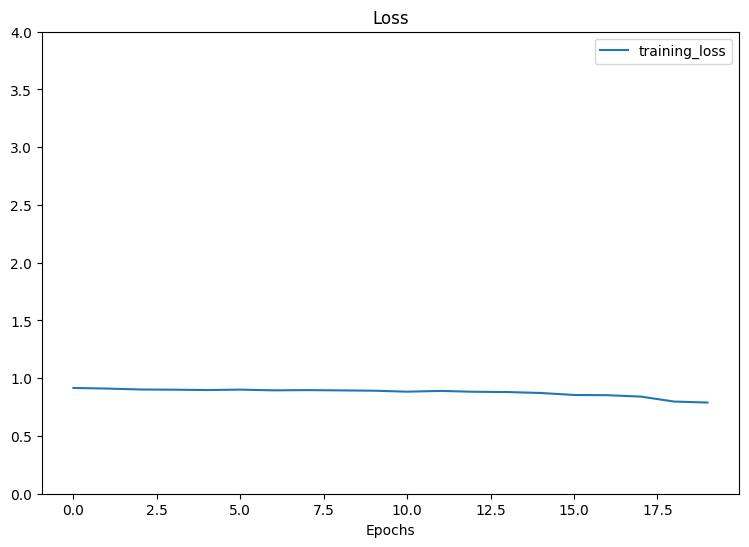

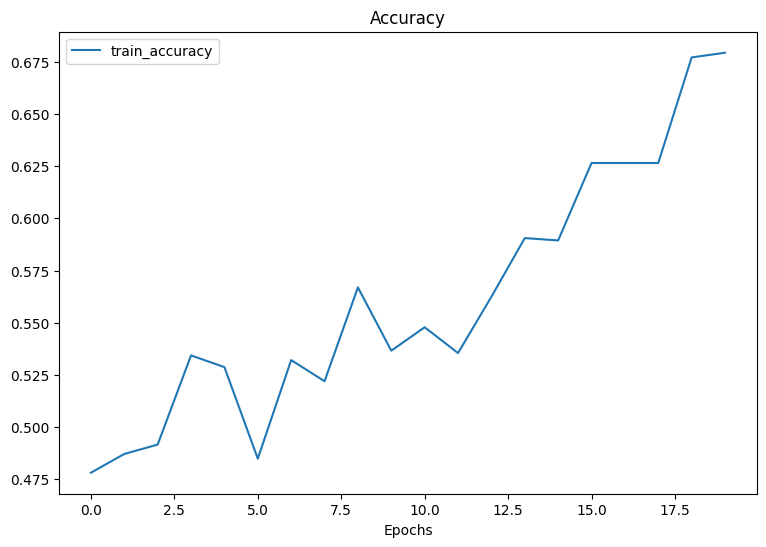

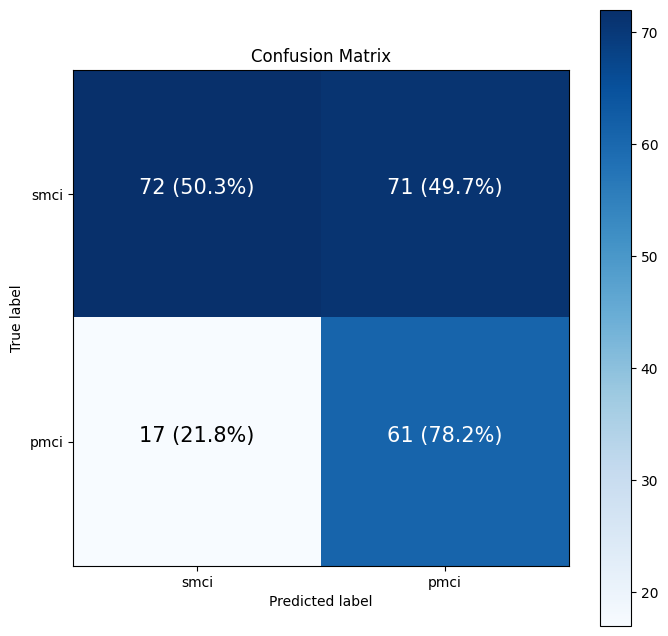

In [ ]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
BEST_LR = 1e-5 # learning rate
BEST_WD= 1e-4 # weight decay
BEST_NUM_EPOCHS = 20 # number of epochs for training
cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate
print(f"Using cosine decay: {cosine_scheduler}")

train_for_more_epochs = False

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    resnet_feature_extractor = ResnetFeatureExtractor(resnet_config=resnet_config, device=device, trained_path=resnet_path, use_pretrained=use_pretrained)
    model = ResNetViT(resnet_feature_extractor, vit_config).to(device)

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=BEST_LR, weight_decay=BEST_WD)
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=BEST_LR, weight_decay=BEST_WD, momentum=0.9, nesterov=True)

optimizer_name = optimizer.__class__.__name__

scheduler = None
if cosine_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7) # T_max=100 for 100 epochs (used in CV)

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    
    # Freeze BatchNorm layers if using pretrained model
    if use_pretrained:
        model.resnet_feature_extractor.model.eval()
    
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    
    if scheduler:
        scheduler.step()

# Save the model if using fixed learning rate in case we want to continue training it
if not cosine_scheduler:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    save_model_dir = "/home/diogommiranda/tese/outputs/resnetvit/" + DATASET + "/" + dir1 + dir2 + str(BATCH_SIZE) + "B/" + "saved_models/" + f"LR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")
        
        training_config = {
            "num_epochs": BEST_NUM_EPOCHS,
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(BEST_LR),
                "weight_decay": float(BEST_WD)
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(save_model_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)